## Project Title: Investigating Bias and Fairness for Alzheimer’s Diagnosis Using the OASIS-2 Dataset

Set UP

In [480]:
!pip install aif360
!pip install wget
!pip install shap

Import Libraries

In [481]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Fairness (AIF360)
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

# Explainability
import shap


Loading Dataset

In [482]:
data = pd.read_excel("/content/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx")
df = pd.DataFrame(data)
df

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1692.880000,0.693926,1.036690
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688.009649,0.675457,1.039686
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319.020000,0.801006,1.330540
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1326.650000,0.795981,1.322890


# Data Description

In [483]:
def print_description(dframe):
  print("\nSHAPE")
  print(dframe.shape)
  print("\nCOLUMNS")
  print(dframe.columns)
  print("\nTYPES")
  print(dframe.dtypes)
  print("\nDESCRIBE")
  print(dframe.describe())
  print()

def print_duplicates(dframe):
  duplID = dframe.duplicated(subset=["Subject ID", "MRI ID"])
  print("ID's that are duplicates:")
  print(duplID[duplID==True])

def print_missing(dframe):
  print("Sum of values that are null")
  print(dframe.isnull().sum())
  print()
  print("Sum of values that are null")
  print(dframe.isna().sum())

In [484]:
# Get description of the data
print_description(df)


SHAPE
(373, 15)

COLUMNS
Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

TYPES
Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV          float64
nWBV          float64
ASF           float64
dtype: object

DESCRIBE
            Visit     MR Delay         Age        EDUC         SES  \
count  373.000000   373.000000  373.000000  373.000000  354.000000   
mean     1.882038   595.104558   77.013405   14.597855    2.460452   
std      0.922843   635.485118    7.640957    2.876339    1.134005   
min      1.000000     0.000000   60.000000    6.000000    1.000000   
25%      1.000000     0.000000   71.000000   12.000000    2.000000   
50%      2.000000   552.000

# Data Exploration

Statistics Summary

In [485]:
# Describe numeric columns
df.describe(include=[np.number])

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.121584,0.729556,1.195460
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.135956,0.037141,0.138105
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1105.652499,0.644399,0.875539
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.330000,0.700191,1.098979
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.041312,0.728789,1.193844
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1596.936793,0.755669,1.292980
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.479526,0.836842,1.587298


Missing Values

In [486]:
# Check for missing values
df.isnull().sum()

,0
Subject ID,0
MRI ID,0
Group,0
Visit,0
MR Delay,0
M/F,0
Hand,0
Age,0
EDUC,0
SES,19


In [487]:
# Unique subjects with missing MMSE and SES values
print(df[df["MMSE"].isna()]["Subject ID"].unique())
print(len(df[df["MMSE"].isna()]["Subject ID"].unique()))
print(df[df["SES"].isna()]["Subject ID"].unique())
print(len(df[df["SES"].isna()]["Subject ID"].unique()))


['OAS2_0181']
1
['OAS2_0002' 'OAS2_0007' 'OAS2_0063' 'OAS2_0099' 'OAS2_0114' 'OAS2_0160'
 'OAS2_0181' 'OAS2_0182']
8


Unique values for categorical data

In [488]:
# List of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Display unique values for each
for col in categorical_cols:
    print(f"\n{col} - Unique values:")
    print(df[col].value_counts())



Subject ID - Unique values:
Subject ID
OAS2_0073    5
OAS2_0048    5
OAS2_0127    5
OAS2_0070    5
OAS2_0027    4
            ..
OAS2_0172    2
OAS2_0177    2
OAS2_0179    2
OAS2_0182    2
OAS2_0184    2
Name: count, Length: 150, dtype: int64

MRI ID - Unique values:
MRI ID
OAS2_0186_MR3    1
OAS2_0001_MR1    1
OAS2_0001_MR2    1
OAS2_0002_MR1    1
OAS2_0002_MR2    1
                ..
OAS2_0005_MR3    1
OAS2_0005_MR2    1
OAS2_0005_MR1    1
OAS2_0004_MR2    1
OAS2_0004_MR1    1
Name: count, Length: 373, dtype: int64

Group - Unique values:
Group
Nondemented    190
Demented       146
Converted       37
Name: count, dtype: int64

M/F - Unique values:
M/F
F    213
M    160
Name: count, dtype: int64

Hand - Unique values:
Hand
R    373
Name: count, dtype: int64


Duplicate Values

In [489]:
# Duplicate MRI ID
for d in df["MRI ID"].duplicated():
  print(d)
# print_duplicates(df)
print(df["MRI ID"].duplicated())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [490]:
# Duplicate Subject ID
for d in df["Subject ID"].duplicated():
  print(d)
# print_duplicates(df)
print(df["Subject ID"].duplicated())

False
True
False
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
False
True
True
False
True
True
False
True
False
True
False
True
False
True
False
True
True
True
False
True
False
True
False
True
False
True
True
False
True
False
True
True
True
False
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
False
True
True
True
True
False
True
True
False
True
False
True
True
False
True
False
True
False
True
False
True
False
True
False
True
True
False
True
True
False
True
False
True
True
False
True
True
False
True
False
True
True
False
True
False
True
True
True
False
True
False
True
False
True
True
True
True
False
True
False
True
True
True
True
False
True
False
True
True
False
True
False
True
True
False
True
True
False
True
True
False
True
False
True
False
True
False
True
Fals

Data without Duplicate Subject ID

In [491]:
# Dataset without duplicated subjects
df_nd = df.drop_duplicates(subset=["Subject ID"])
# print_unique Subject ID(df_nd)
print(df_nd["Subject ID"].duplicated())

0      False
2      False
5      False
7      False
10     False
       ...  
359    False
361    False
365    False
367    False
370    False
Name: Subject ID, Length: 150, dtype: bool


Distribution of Numeric figures

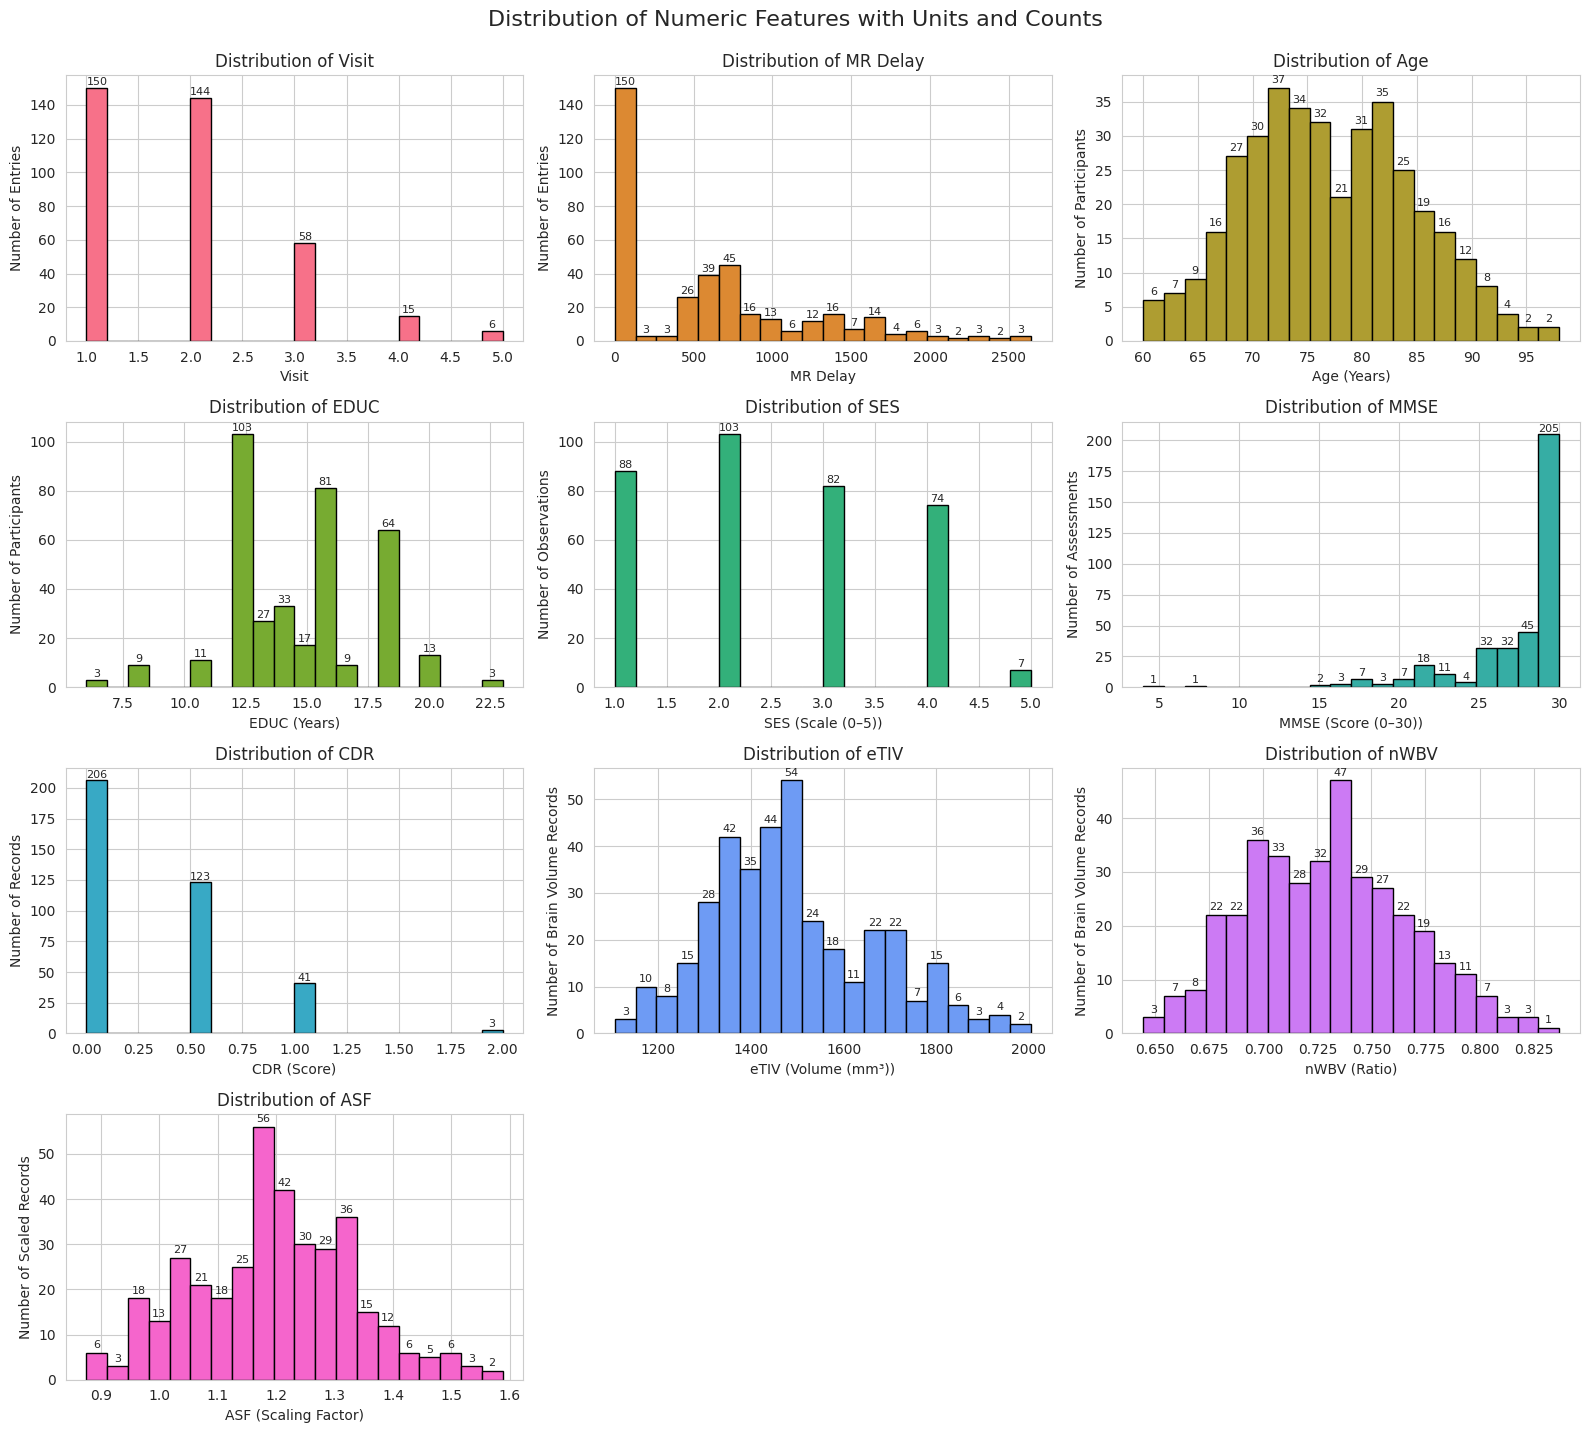

In [492]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a colorful style
sns.set_style("whitegrid")

# List numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Y-axis context labels
y_axis_labels = {
    'Age': 'Number of Participants',
    'MMSE': 'Number of Assessments',
    'EDUC': 'Number of Participants',
    'CDR': 'Number of Records',
    'SES': 'Number of Observations',
    'eTIV': 'Number of Brain Volume Records',
    'nWBV': 'Number of Brain Volume Records',
    'ASF': 'Number of Scaled Records',
}

# X-axis units (adjust as needed)
x_axis_units = {
    'Age': 'Years',
    'MMSE': 'Score (0–30)',
    'EDUC': 'Years',
    'CDR': 'Score',
    'SES': 'Scale (0–5)',
    'eTIV': 'Volume (mm³)',
    'nWBV': 'Ratio',
    'ASF': 'Scaling Factor',
}

# Create histograms with formatted bins and count annotations
fig, axes = plt.subplots(nrows=len(numeric_cols)//3 + 1, ncols=3, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    data = df[col].dropna()

    # Compute histogram data
    counts, bins, patches = axes[i].hist(data, bins=20, edgecolor='black',
                                         color=sns.color_palette("husl", len(numeric_cols))[i])

    # Title
    axes[i].set_title(f'Distribution of {col}', fontsize=12)

    # X-axis label with unit
    x_unit = x_axis_units.get(col, '')
    x_label = f"{col} ({x_unit})" if x_unit else col
    axes[i].set_xlabel(x_label, fontsize=10)

    # Y-axis label with context
    ylabel = y_axis_labels.get(col, 'Number of Entries')
    axes[i].set_ylabel(ylabel, fontsize=10)

    # Add count values on bars
    for j in range(len(patches)):
        height = counts[j]
        if height > 0:
            bin_center = 0.5 * (bins[j] + bins[j+1])
            axes[i].text(bin_center, height + 0.5, str(int(height)),
                         ha='center', va='bottom', fontsize=8)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution of Numeric Features with Units and Counts", fontsize=16, y=1.02)
plt.show()


Visualize Correlations Heatmap

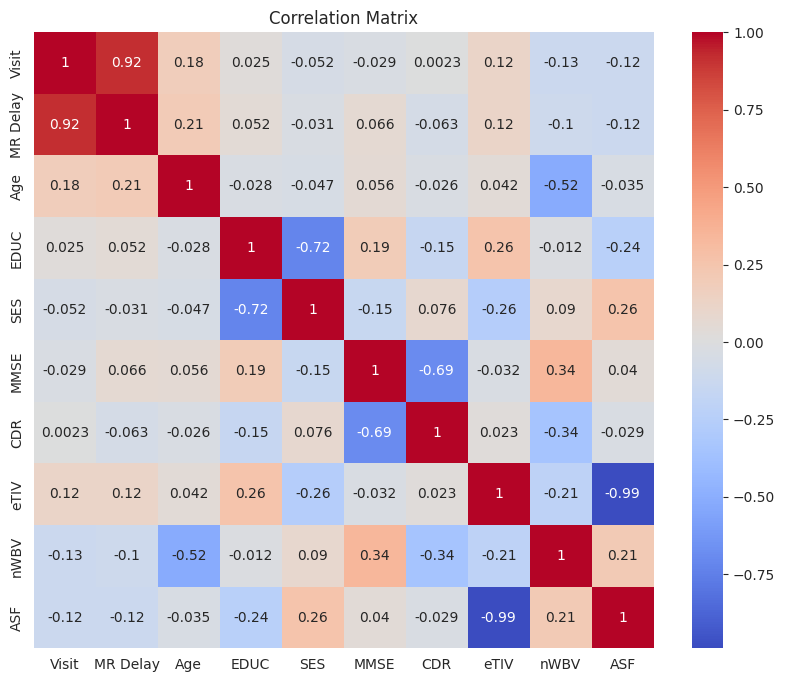

In [493]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Boxplot

<ipython-input-494-a2adfc86522b>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=feature, data=df, palette=group_palette)
<ipython-input-494-a2adfc86522b>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=feature, data=df, palette=group_palette)
<ipython-input-494-a2adfc86522b>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=feature, data=df, palette=group_palette)
<ipython-input-494-a2adfc86522b>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.

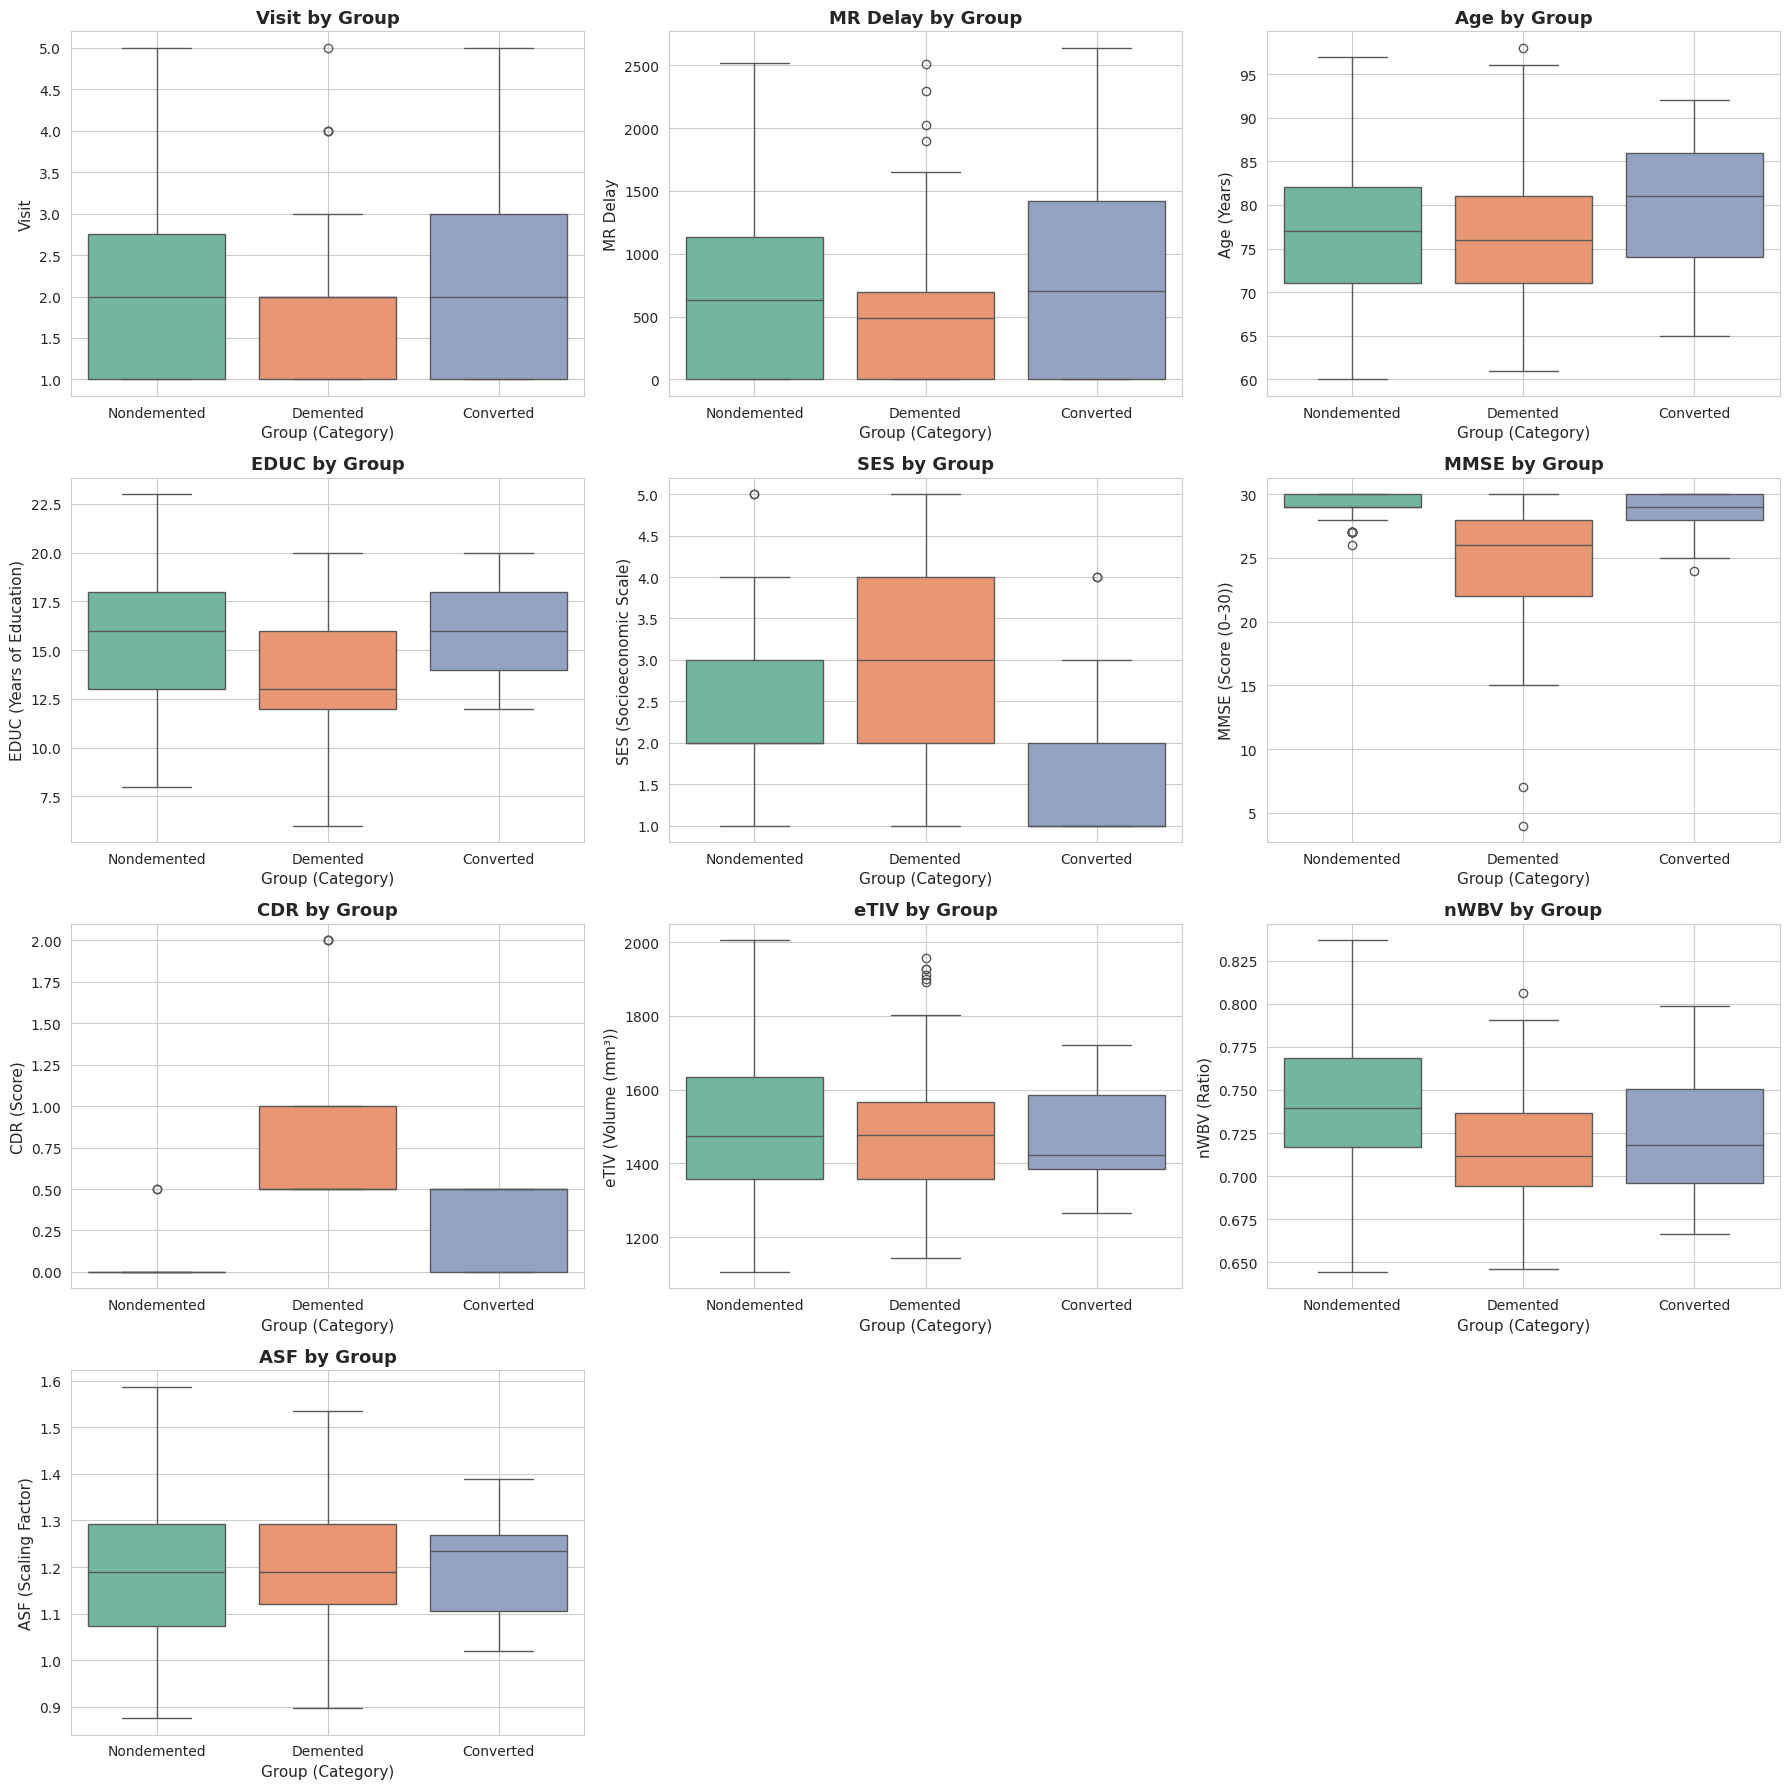

In [494]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get all numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Set plot style
sns.set_style("whitegrid")

# Color palette for each group
unique_groups = df['Group'].unique()
palette = sns.color_palette("Set2", len(unique_groups))
group_palette = dict(zip(unique_groups, palette))

# Define units for each feature (customize based on dataset documentation)
feature_units = {
    'Age': 'Years',
    'MMSE': 'Score (0–30)',
    'EDUC': 'Years of Education',
    'CDR': 'Score',
    'SES': 'Socioeconomic Scale',
    'eTIV': 'Volume (mm³)',
    'nWBV': 'Ratio',
    'ASF': 'Scaling Factor',
    # Add more if needed...
}

# Subplot layout
n_features = len(numeric_features)
n_cols = 3
n_rows = n_features // n_cols + (n_features % n_cols > 0)

# Dynamic figure size
plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))

# Create boxplots
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='Group', y=feature, data=df, palette=group_palette)

    # Title and axis labels
    plt.title(f'{feature} by Group', fontsize=13, fontweight='bold')
    plt.xlabel('Group (Category)', fontsize=11)

    unit = feature_units.get(feature, '')  # Fallback to no unit if not defined
    ylabel = f'{feature} ({unit})' if unit else feature
    plt.ylabel(ylabel, fontsize=11)
    plt.grid(True)

plt.tight_layout()
plt.show()

Number of Participants by Group (Demented, Nondemented and Converted)

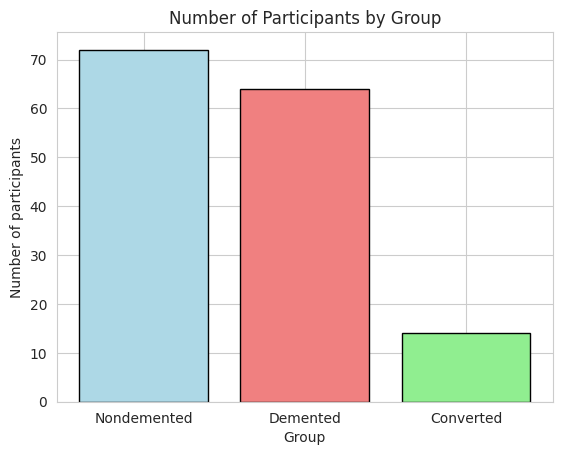

Group
Nondemented    72
Demented       64
Converted      14
Name: count, dtype: int64


In [495]:
group_counts = df_nd["Group"].value_counts()

# Define g_colours (example)
g_colours = [
    {"bg": "lightblue", "edge": "black"},  # Nondemented
    {"bg": "lightcoral", "edge": "black"},  # Demented
    {"bg": "lightgreen", "edge": "black"}   # Converted (if you have this group)
]

# Accessing colors using group_counts.index
g_cbg = [g_colours[group_counts.index.get_loc(group)]["bg"] for group in group_counts.index]
g_ce = [g_colours[group_counts.index.get_loc(group)]["edge"] for group in group_counts.index]

plt.bar(group_counts.index, group_counts, color=g_cbg, edgecolor=g_ce)
plt.title("Number of Participants by Group")
plt.ylabel("Number of participants")
plt.xlabel("Group")
plt.savefig("O2_particpants_by_group.png")
plt.show()

print(group_counts)

Age Bins

In [496]:
initial_visit = df[df["Visit"]==1]

age_bins = [{"Age":"Age < 60","dataframe":initial_visit.query('Age < 60')}]
start = 60
for i in range(0,6):
  q_string = "Age >= " + str(start) + ' and Age < ' + str(start + 6)
  age_bins+=[{"Age": str(start) + " <= Age < " +str(start + 6), "dataframe":initial_visit.query(q_string)}]
  start += 6


age_bins+=[{"Age":"Age >= 96", "dataframe":initial_visit.query("Age >= "+ str(start))}]

for a in age_bins:
  print(f'\tAge range: {a["Age"]}\t\tNumber of Subjects:{len(a["dataframe"]["Subject ID"].unique())}')

	Age range: Age < 60		Number of Subjects:0
	Age range: 60 <= Age < 66		Number of Subjects:12
	Age range: 66 <= Age < 72		Number of Subjects:37
	Age range: 72 <= Age < 78		Number of Subjects:43
	Age range: 78 <= Age < 84		Number of Subjects:37
	Age range: 84 <= Age < 90		Number of Subjects:17
	Age range: 90 <= Age < 96		Number of Subjects:3
	Age range: Age >= 96		Number of Subjects:1


In [497]:
# Mean Median Mode of Age
print(df_nd["Age"].mean())
print(df_nd["Age"].median())
print(df_nd["Age"].mode())

75.44666666666667
75.0
0    73
Name: Age, dtype: int64


Information regarding Number of visits

In [498]:
deltaV = [0]
visit_count = df['Visit'].value_counts() # Changed 'visit' to 'df['Visit']'
print(visit_count)
for index, v in enumerate(visit_count):
  if index>0:
      # print(abs(visit_count[index] -visit_count[index+1])/visit_count[index])
      deltaV += [100*abs(visit_count[index] -visit_count[index+1])/visit_count[index]]

deltaV=pd.DataFrame({"Delta_visit":deltaV})
print(deltaV)

Visit
1    150
2    144
3     58
4     15
5      6
Name: count, dtype: int64
   Delta_visit
0     0.000000
1     4.000000
2    59.722222
3    74.137931
4    60.000000


Distribution of Dataset on the basis of Hand

Text(0.5, 0, 'Hand')

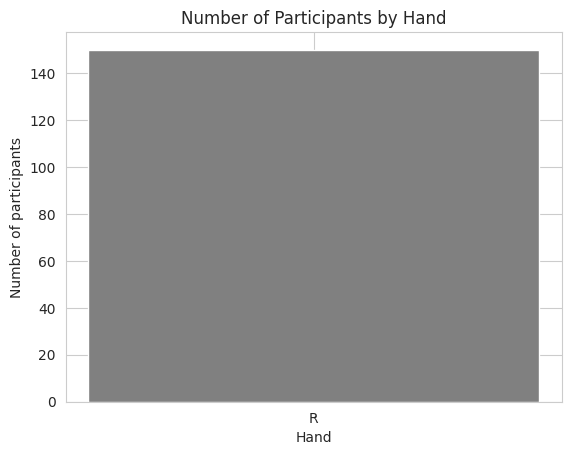

In [499]:
hand_counts =  df_nd["Hand"].value_counts()
plt.bar(hand_counts.index, hand_counts,color=['grey','red'])
plt.title("Number of Participants by Hand")
plt.ylabel("Number of participants")
plt.xlabel("Hand")

Sex Distribution

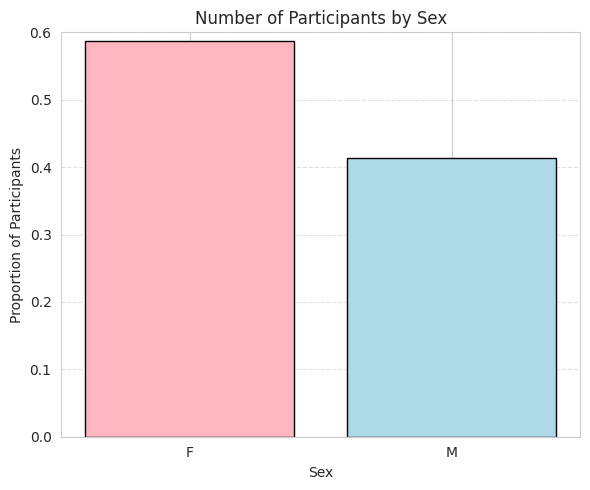

M/F
F    88
M    62
Name: count, dtype: int64


In [500]:
import matplotlib.pyplot as plt

# Define s_colors with background (bg) and edge (edge) colors for F and M
s_colors = [
    {"bg": "lightpink", "edge": "black"},  # F
    {"bg": "lightblue", "edge": "black"}   # M
]

# Count number of participants by sex
sex_counts = df_nd["M/F"].value_counts()
sex_total = sex_counts.sum()

# Map consistent colors for F and M using defined s_colors
label_order = ['F', 'M']
s_cbg = [s_colors[0]['bg'], s_colors[1]['bg']]  # Background colors
s_ce = [s_colors[0]['edge'], s_colors[1]['edge']]  # Edge colors

# Ensure correct order of bars
sex_counts = sex_counts.reindex(label_order).fillna(0)

# Plot
plt.figure(figsize=(6, 5))
plt.bar(sex_counts.index, sex_counts / sex_total, color=s_cbg, edgecolor=s_ce)

plt.title("Number of Participants by Sex")
plt.ylabel("Proportion of Participants")
plt.xlabel("Sex")
plt.ylim(0, 0.6)  # Limit y-axis to 0.6
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
# plt.savefig("O2_sex_demographics.png")
plt.show()

print(sex_counts)

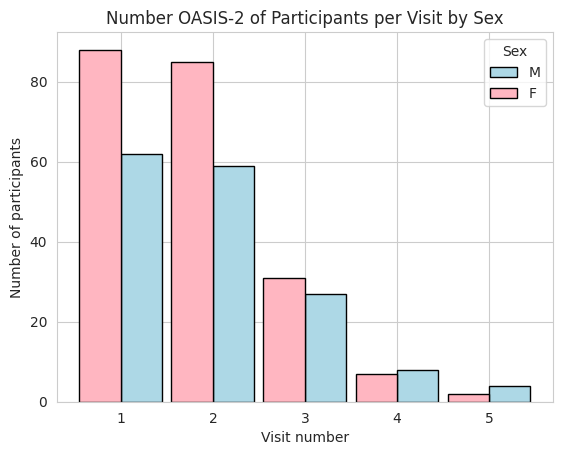

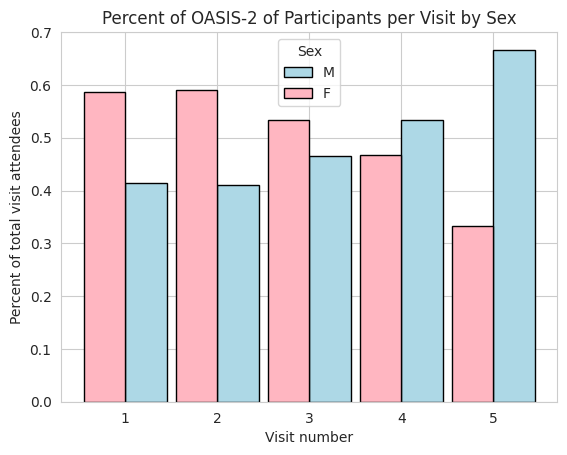

In [501]:
m_only = df[df["M/F"]=="M"]
f_only = df[df["M/F"]=="F"]

visit_total = df["Visit"].sort_values().value_counts()


plt.bar(m_only["Visit"].sort_values().unique(), m_only["Visit"].sort_values().value_counts(),color=s_colors[1]['bg'],edgecolor=s_colors[1]["edge"], label="M", width=0.45, align='edge')
plt.bar(f_only["Visit"].sort_values().unique(), f_only["Visit"].sort_values().value_counts(),color=s_colors[0]['bg'],edgecolor=s_colors[0]["edge"], label="F", width=-0.45, align='edge')

plt.title("Number OASIS-2 of Participants per Visit by Sex")
plt.xticks(ticks=[1,2,3,4,5])
plt.xlabel("Visit number")
plt.ylabel("Number of participants")
plt.legend(title="Sex")
plt.savefig("O2_parts_by_sex.png")
plt.show()



plt.bar(m_only["Visit"].sort_values().unique(), m_only["Visit"].sort_values().value_counts()/visit_total,color=s_colors[1]['bg'],edgecolor=s_colors[1]["edge"], label="M", width=0.45, align='edge')
plt.bar(f_only["Visit"].sort_values().unique(), f_only["Visit"].sort_values().value_counts()/visit_total,color=s_colors[0]['bg'],edgecolor=s_colors[0]["edge"], label="F", width=-0.45, align='edge')

plt.title("Percent of OASIS-2 of Participants per Visit by Sex")
plt.xticks(ticks=[1,2,3,4,5])
plt.xlabel("Visit number")
plt.ylabel("Percent of total visit attendees")
plt.legend(title="Sex")
plt.savefig("O2_percent_visit_by_sex.png")
plt.show()


<ipython-input-502-d058e6991bc8>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i]//2, y[i], ha = 'center')
<ipython-input-502-d058e6991bc8>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i]//2 + b[i], y[i], ha = 'center')


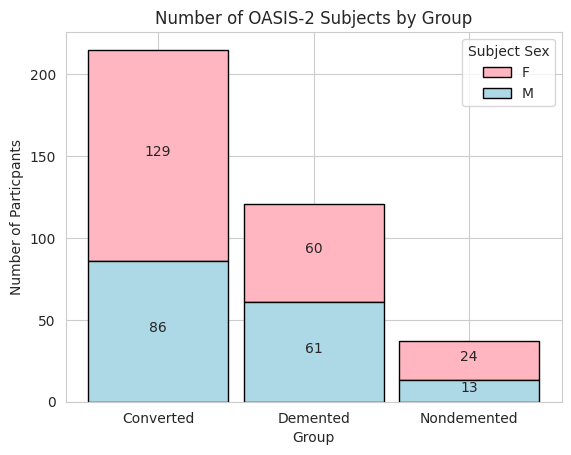

In [502]:
def addlabels_b(x,y):
    for i in range(0,len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')


def addlabels_t(x,y,b):
    for i in range(0,len(x)):
        plt.text(i, y[i]//2 + b[i], y[i], ha = 'center')


plt.bar(f_only["Group"].sort_values().unique(), f_only["Group"].sort_values().value_counts(),color=s_colors[0]['bg'],edgecolor=s_colors[0]["edge"], label="F", width=0.9, align='center',  bottom=m_only["Group"].sort_values().value_counts())
plt.bar(m_only["Group"].sort_values().unique(), m_only["Group"].sort_values().value_counts(),color=s_colors[1]['bg'],edgecolor=s_colors[1]["edge"], label="M", width=0.9, align='center', bottom=np.array([0,0,0]))




addlabels_b(m_only["Group"].sort_values().unique(), m_only["Group"].sort_values().value_counts())

addlabels_t(f_only["Group"].sort_values().unique(), f_only["Group"].sort_values().value_counts(),m_only["Group"].sort_values().value_counts())

plt.title("Number of OASIS-2 Subjects by Group")
plt.xlabel("Group")
plt.ylabel("Number of Particpants")
plt.legend(title="Subject Sex")
plt.savefig("O2_particpants_by_group_sex.png")
plt.show()

Visits by Group

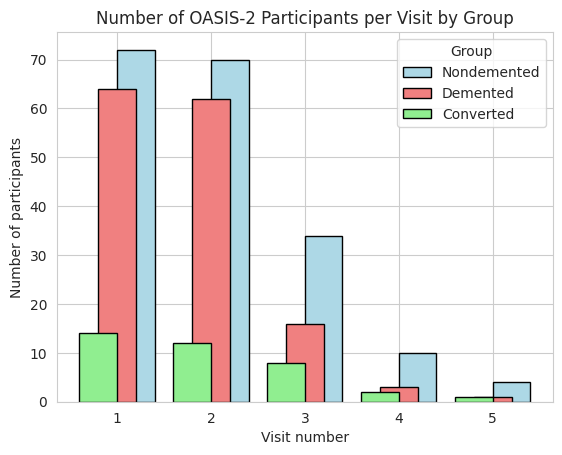

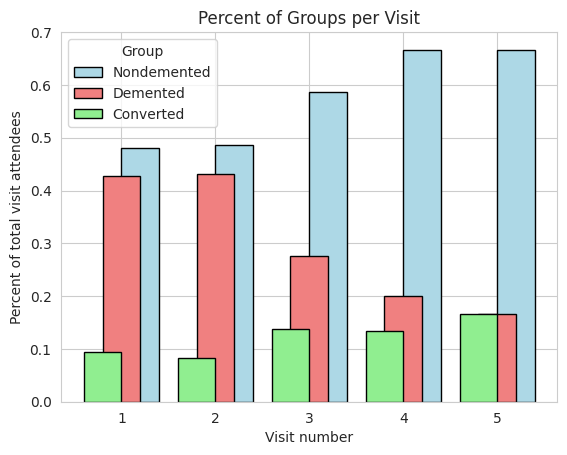

In [503]:
non_group = df[df["Group"]=="Nondemented"]
dem_group = df[df["Group"]=="Demented"]
con_group = df[df["Group"]=="Converted"]

group_names = df["Group"].unique()
width=[0.4,0.4,-0.4]
align=['edge','center','edge']

for i,g in enumerate(group_names):
  plt.bar(df[df["Group"]==g]["Visit"].sort_values().unique(), df[df["Group"]==g]["Visit"].sort_values().value_counts(),color=g_colours[i]["bg"], edgecolor=g_colours[i]["edge"],label=g, width=width[i], align=align[i])


plt.title("Number of OASIS-2 Participants per Visit by Group")
plt.xticks(ticks=[1,2,3,4,5])
plt.xlabel("Visit number")
plt.ylabel("Number of participants")
plt.legend(title="Group")
plt.savefig("O2_visit_parts_by_group.png")
plt.show()


for i,g in enumerate(group_names):
  plt.bar(df[df["Group"]==g]["Visit"].sort_values().unique(), df[df["Group"]==g]["Visit"].sort_values().value_counts()/visit_total,color=g_colours[i]["bg"], edgecolor=g_colours[i]["edge"],label=g, width=width[i], align=align[i])

# plt.bar(non_group["Visit"].sort_values().unique(), non_group["Visit"].sort_values().value_counts()/visit_total, label="Nondemented", width=0.4, align='edge')
# plt.bar(dem_group["Visit"].sort_values().unique(), dem_group["Visit"].sort_values().value_counts()/visit_total, label="Demented", width=0.4, align='center')
# plt.bar(con_group["Visit"].sort_values().unique(), con_group["Visit"].sort_values().value_counts()/visit_total, label="Converted", width=-0.4, align='edge')

# plt.plot(non_group["Visit"].sort_values().unique(), non_group["Visit"].sort_values().value_counts()/visit_total,color=('darkred', 0.5), label="Nondemented")
# plt.plot(dem_group["Visit"].sort_values().unique(), dem_group["Visit"].sort_values().value_counts()/visit_total,color=('blue', 0.5), label="Demented")
# plt.plot(con_group["Visit"].sort_values().unique(), con_group["Visit"].sort_values().value_counts()/visit_total,color=('green', 0.5), label="Converted")

plt.title("Percent of Groups per Visit")
plt.xticks(ticks=[1,2,3,4,5])
plt.xlabel("Visit number")
plt.ylabel("Percent of total visit attendees")
plt.savefig("O2_percent_visit_parts_by_group.png")
plt.legend(title="Group")
plt.show()

# Data Preprocessing

Taking Last Visit of each Subject because of Duplicate Subject ID and Number of Visits are inconsistent

In [504]:
# Convert Visit date or year column if needed (OASIS-2 often uses 'Visit' or 'MRI ID')
# Example: use 'Visit' column (visit numbers)
# Or if using a date column like 'VisitDate', convert it to datetime
# Display original dataset shape
print("Original Dataset:")
print(df.head())
print(f"\nTotal Rows: {df.shape[0]}\n")

# Sort by Subject ID and Visit (assuming higher visit number is later)
df_sorted = df.sort_values(by=['Subject ID', 'Visit'])

# Keep only the last visit for each Subject ID
df_last_visits = df_sorted.groupby('Subject ID').tail(1).reset_index(drop=True)

# Save or display
print(df_last_visits.head())
# df_last_visits.to_csv('oasis_last_visits.csv', index=False)


# Display filtered dataset
print("Filtered Dataset (Only Last Visit Per Subject):")
print(df_last_visits.head())
print(f"\nTotal Rows: {df_last_visits.shape[0]}")


Original Dataset:
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR         eTIV      nWBV       ASF  
0  2.0  27.0  0.0  1986.550000  0.696106  0.883440  
1  2.0  30.0  0.0  2004.479526  0.681062  0.875539  
2  NaN  23.0  0.5  1678.290000  0.736336  1.045710  
3  NaN  28.0  0.5  1737.620000  0.713402  1.010000  
4  NaN  22.0  0.5  1697.911134  0.701236  1.033623  

Total Rows: 373

  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14 

In [505]:
for d in df_last_visits["Subject ID"].duplicated():
  print(d)
# print_duplicates(df)
print(df_last_visits["Subject ID"].duplicated())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
0      False
1      False
2      False
3      False
4      False
       ...  
145    False
146    Fa

Removing Hand from the features because all subjects are right handed and it create bias

In [506]:
# Remove cols with only one distinct value
df_last_visits.drop(["Hand"], axis=1, inplace=True)

In [507]:
# Check missing values by each column
pd.isnull(df_last_visits).sum()

,0
Subject ID,0
MRI ID,0
Group,0
Visit,0
MR Delay,0
M/F,0
Age,0
EDUC,0
SES,8
MMSE,1


Handling missing values

In [508]:
# Dropped the rows with missing values in the column, SES and MMSE
df_last_visits_dropna = df_last_visits.dropna(axis=0, how='any')
pd.isnull(df_last_visits_dropna).sum()

,0
Subject ID,0
MRI ID,0
Group,0
Visit,0
MR Delay,0
M/F,0
Age,0
EDUC,0
SES,0
MMSE,0


Correlation Heatmap

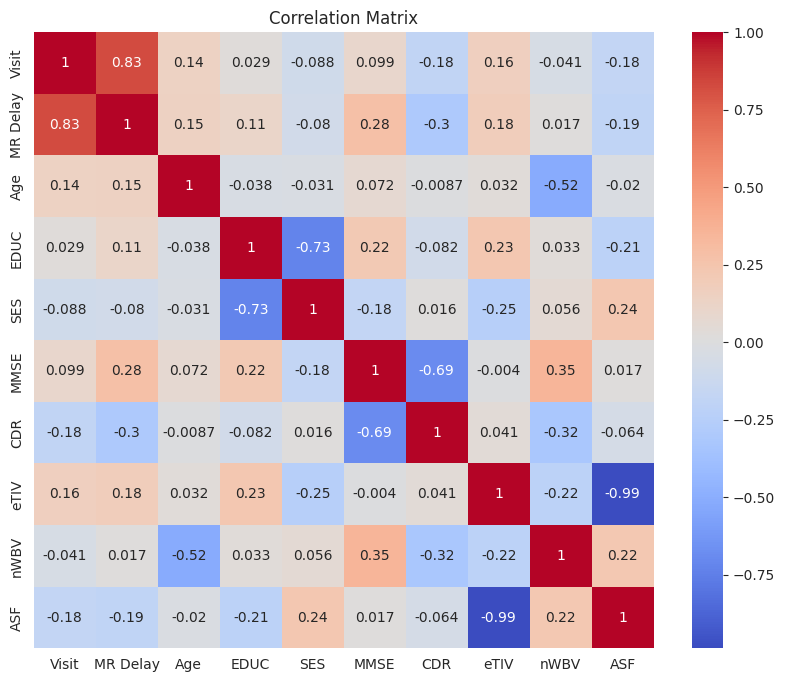

In [509]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_last_visits_dropna.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Converting CDR 0 into 0 and 1, 2, 3 into 1

In [510]:
# Binarise target variable
df_last_visits_dropna["CDR"] = df_last_visits["CDR"].map({0: 0, 0.5: 1, 1: 1, 2: 1, 3: 1})

<ipython-input-510-a7a9d9835048>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_visits_dropna["CDR"] = df_last_visits["CDR"].map({0: 0, 0.5: 1, 1: 1, 2: 1, 3: 1})


Now according to CDR 0 and 1, 0 considered as nondemented and 1 considered as demented

In [511]:
# Reclassify Group based on CDR values
df_last_visits_dropna['Group'] = df_last_visits_dropna['CDR'].apply(
    lambda x: 'Nondemented' if x == 0 else 'Demented'
)

# Verify the changes
print("Value counts after reclassification:")
print(df_last_visits_dropna['Group'].value_counts())

# Show samples with CDR and new Group classification
print("\nSample records with CDR and Group:")
print(df_last_visits_dropna[['CDR', 'Group']].head(30))

Value counts after reclassification:
Group
Nondemented    73
Demented       69
Name: count, dtype: int64

Sample records with CDR and Group:
    CDR        Group
0     0  Nondemented
2     0  Nondemented
3     0  Nondemented
5     0  Nondemented
6     1     Demented
7     1     Demented
8     0  Nondemented
9     0  Nondemented
10    1     Demented
11    1     Demented
12    0  Nondemented
13    1     Demented
14    1     Demented
15    1     Demented
16    0  Nondemented
17    1     Demented
18    1     Demented
19    0  Nondemented
20    1     Demented
21    0  Nondemented
22    0  Nondemented
23    1     Demented
24    1     Demented
25    0  Nondemented
26    0  Nondemented
27    0  Nondemented
28    1     Demented
29    1     Demented
30    1     Demented
31    1     Demented


<ipython-input-511-b23da5430faa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_visits_dropna['Group'] = df_last_visits_dropna['CDR'].apply(


# Normalization, One Hot encoding and Train:Test:Validation

In [512]:
# Set random seed for reproducible synthetic dataset
np.random.seed(42)

# Simulated df_last_visits_dropna DataFrame with 142 samples
df_last_visits_dropna = pd.DataFrame({
    'Group': np.random.choice(['Demented', 'Nondemented'], 142),
    'M/F': np.random.choice(['M', 'F'], 142),
    'Age': np.random.randint(60, 96, 142),
    'EDUC': np.random.randint(6, 24, 142),
    'CDR' : np.random.choice([0, 1], 142),
    'MMSE': np.random.uniform(10, 30, 142),
    'eTIV': np.random.uniform(1100, 2000, 142),
    'nWBV': np.random.uniform(0.65, 0.85, 142),
})

# Separate features and target
y = df_last_visits_dropna['Group'].values
X = df_last_visits_dropna[['M/F', 'Age', 'EDUC', 'CDR', 'MMSE', 'eTIV', 'nWBV']].copy()

# Define categorical and numerical columns
categorical_cols = ['M/F']
numerical_cols = ['Age', 'EDUC', 'CDR', 'MMSE', 'eTIV', 'nWBV']

# First split: 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Second split: ~17.65% of remaining data for validation (~15% of full)
val_size = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size,
    random_state=42,
    stratify=y_temp
)

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert to DataFrames for inspection
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=preprocessor.get_feature_names_out())
X_val_preprocessed = pd.DataFrame(X_val_preprocessed, columns=preprocessor.get_feature_names_out())
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=preprocessor.get_feature_names_out())

# Return shapes to confirm 70:15:15 split
X_train_preprocessed.shape[0], X_val_preprocessed.shape[0], X_test_preprocessed.shape[0]


(98, 22, 22)

Encoding the Group by using LabelEncoding

In [513]:
# Encode the target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Inspect first 30 samples of preprocessed training data
print("First 30 preprocessed training samples (X):")
print(X_train_preprocessed.head(30))  # Shows first 30 rows

print("\nFirst 30 encoded training labels (y):")
print(y_train_encoded[:30])  # Shows first 30 encoded labels


First 30 preprocessed training samples (X):
    num__Age  num__EDUC  num__CDR  num__MMSE  num__eTIV  num__nWBV  cat__M/F_M
0   0.882353   0.352941       0.0   0.354989   0.622924   0.856508         0.0
1   0.764706   0.941176       0.0   0.871963   0.618629   0.000000         1.0
2   0.470588   0.705882       1.0   0.266281   0.792386   0.013752         0.0
3   0.029412   0.470588       0.0   0.068226   0.797982   0.897814         0.0
4   0.470588   0.058824       0.0   0.577677   0.256908   0.692109         1.0
5   0.705882   0.941176       1.0   0.194676   0.913920   0.720891         0.0
6   0.294118   0.882353       0.0   0.100503   0.772688   0.215072         1.0
7   0.705882   0.000000       1.0   0.836182   0.232899   0.445014         1.0
8   0.970588   0.294118       1.0   0.986290   0.311384   0.338148         0.0
9   0.558824   0.294118       1.0   0.607884   0.584366   0.005192         0.0
10  0.794118   0.000000       0.0   0.840029   0.136910   0.927525         1.0
11  0.79

Training the Models

Logistic Regression

Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

Training Accuracy:   0.6633
Validation Accuracy: 0.5455
Test Accuracy:       0.5455

Test Set Classification Report:
              precision    recall  f1-score   support

    Demented       0.50      0.40      0.44        10
 Nondemented       0.57      0.67      0.62        12

    accuracy                           0.55        22
   macro avg       0.54      0.53      0.53        22
weighted avg       0.54      0.55      0.54        22



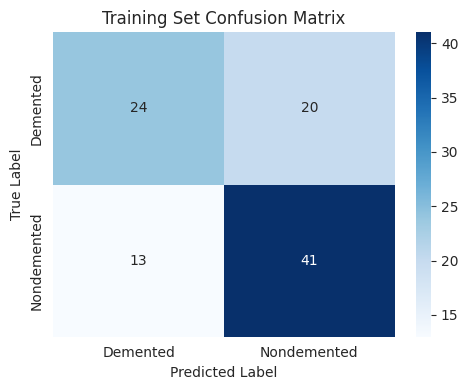

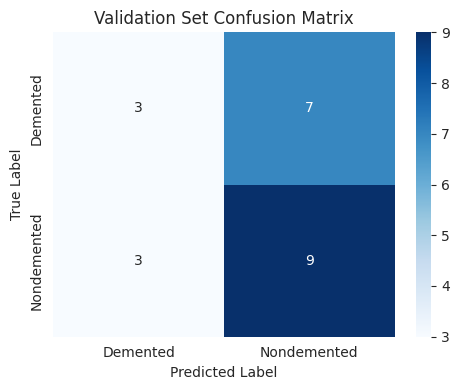

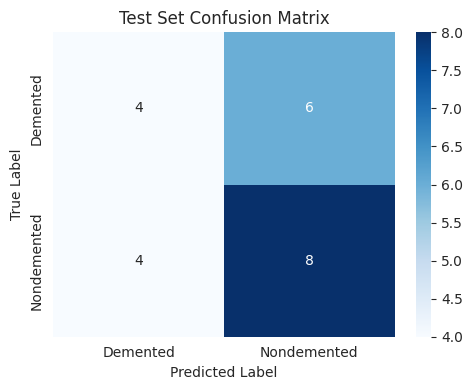

In [514]:
# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

# Initialize and fit model with GridSearchCV
log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_preprocessed, y_train_encoded)

# Best model
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred_train = best_log_reg.predict(X_train_preprocessed)
y_pred_val = best_log_reg.predict(X_val_preprocessed)
y_pred_test = best_log_reg.predict(X_test_preprocessed)

# Accuracy scores
train_acc = accuracy_score(y_train_encoded, y_pred_train)
val_acc = accuracy_score(y_val_encoded, y_pred_val)
test_acc = accuracy_score(y_test_encoded, y_pred_test)

# Display accuracy
print("Best Parameters:", grid_search.best_params_)
print(f"\nTraining Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test_encoded, y_pred_test, target_names=le.classes_))

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot all confusion matrices
plot_conf_matrix(y_train_encoded, y_pred_train, "Training Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_val_encoded, y_pred_val, "Validation Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_test_encoded, y_pred_test, "Test Set Confusion Matrix", le.classes_)


Analyze Fairness of Logistic Regression

In [515]:
# Get predictions from the best model
y_pred_best = grid_search.best_estimator_.predict(X_test_preprocessed)

# Reconstruct the 'M/F' sensitive attribute from original test data
X_test_with_gender = X_test.copy()
X_test_with_gender['M/F'] = X_test['M/F'].apply(lambda x: 1 if x == 'M' else 0)  # 1 = Male, 0 = Female

# Create BinaryLabelDataset for true labels
test_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([
        X_test_with_gender.reset_index(drop=True),
        pd.Series(y_test_encoded, name='label')
    ], axis=1),
    label_names=['label'],
    protected_attribute_names=['M/F']
)

# Create BinaryLabelDataset for predicted labels
pred_dataset = test_dataset.copy()
pred_dataset.labels = y_pred_best.reshape(-1, 1)

# Define privileged and unprivileged groups
privileged_groups = [{'M/F': 1}]      # Males
unprivileged_groups = [{'M/F': 0}]    # Females

# Compute fairness metrics
metric = ClassificationMetric(
    test_dataset, pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Extract fairness metrics
equal_opportunity_diff = metric.equal_opportunity_difference()
average_odds_diff = metric.average_odds_difference()
stat_parity_diff = metric.statistical_parity_difference()
disparate_impact = metric.disparate_impact()
theil_index = metric.theil_index()

# Print results
print("\n Fairness Metrics for Logistic Regression:")
print(f"EOD:     {equal_opportunity_diff:.4f}")
print(f"AOD:     {average_odds_diff:.4f}")
print(f"SPD:     {stat_parity_diff:.4f}")
print(f"DI:      {disparate_impact:.4f}")
print(f"TI:      {theil_index:.4f}")



 Fairness Metrics for Logistic Regression:
EOD:     0.1250
AOD:     0.0625
SPD:     0.0513
DI:      1.0833
TI:      0.2596


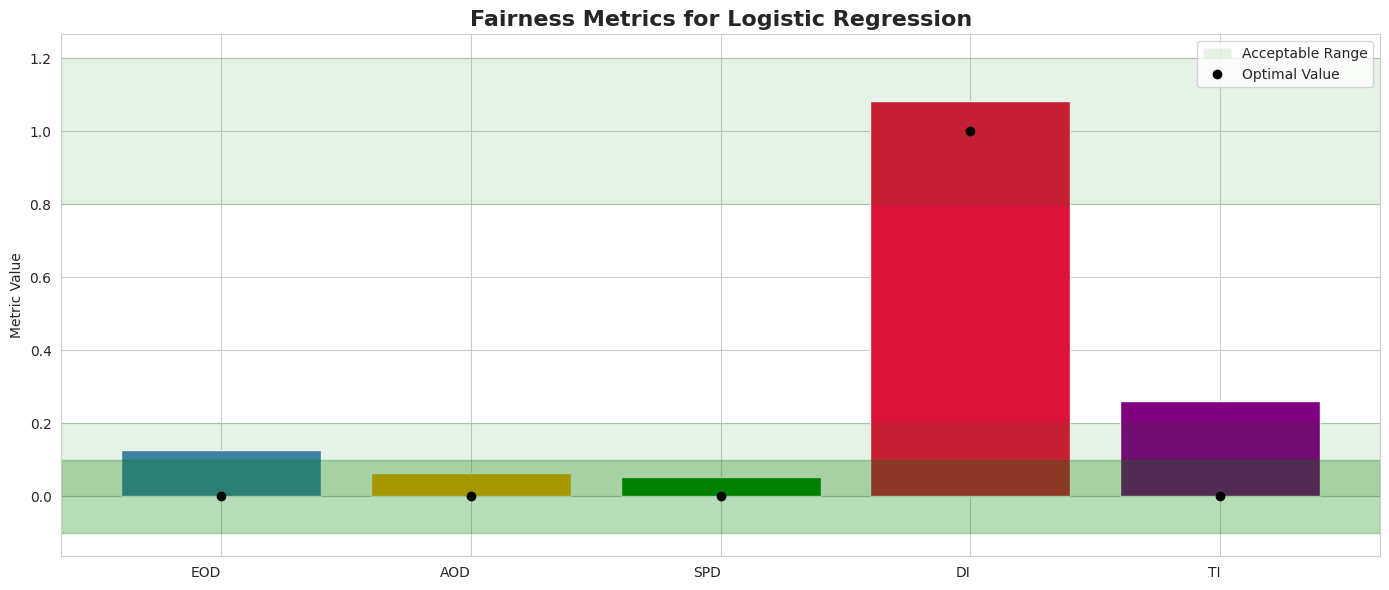

In [516]:
# Fairness metric values for Logistic Regression
metrics = {
    "EOD": 0.1250,
    "AOD": 0.0625,
    "SPD": 0.0513,
    "DI": 1.0833,
    "TI": 0.2596
}

# Optimal values for each metric (the ideal target)
optimal_values = [0, 0, 0, 1, 0]

# Acceptable range for each metric (used for green background bands)
acceptable_range = {
    "min": [-0.1, -0.1, -0.1, 0.8, 0],
    "max": [0.1, 0.1, 0.1, 1.2, 0.2]
}

# Plot setup
labels = list(metrics.keys())
values = list(metrics.values())
colors = ['steelblue', 'orange', 'green', 'crimson', 'purple']

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(labels, values, color=colors)

# Add acceptable range as shaded regions
for i, label in enumerate(labels):
    ax.axhspan(acceptable_range["min"][i], acceptable_range["max"][i],
               color='green', alpha=0.1)

# Add optimal value as black dot
for i, opt in enumerate(optimal_values):
    ax.plot(i, opt, marker='o', color='black', markersize=6, label='Optimal Value' if i == 0 else "")

# Styling
ax.set_title("Fairness Metrics for Logistic Regression", fontsize=16, fontweight='bold')
ax.set_ylabel("Metric Value")
plt.xticks(rotation=0, ha='right')

# Custom legend
legend_elements = [
    Patch(facecolor='green', alpha=0.1, label='Acceptable Range'),
    plt.Line2D([0], [0], marker='o', color='black', label='Optimal Value', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


SHAP Summary for Explainability of features on Logistic Regression

<ipython-input-517-6abc5d8da71c>:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())


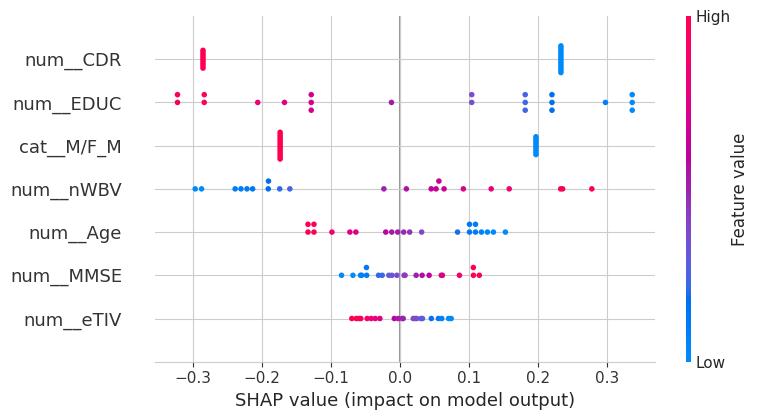

In [517]:
# Use a sample of the training set for SHAP explanation (to keep it fast & interpretable)
X_sample = X_train_preprocessed[:100]  # You can adjust the sample size

# Create an explainer using SHAP's linear explainer (since you're using logistic regression)
# Replace 'logistic_best_model' with 'best_log_reg'
explainer = shap.Explainer(best_log_reg, X_sample, feature_names=preprocessor.get_feature_names_out())

# Compute SHAP values for the test set
shap_values = explainer(X_test_preprocessed)

# Summary plot: Shows global feature importance
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

SVM

Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'poly'}

Training Accuracy:   0.7449
Validation Accuracy: 0.5909
Test Accuracy:       0.4545

Test Set Classification Report:
              precision    recall  f1-score   support

    Demented       0.25      0.10      0.14        10
 Nondemented       0.50      0.75      0.60        12

    accuracy                           0.45        22
   macro avg       0.38      0.42      0.37        22
weighted avg       0.39      0.45      0.39        22



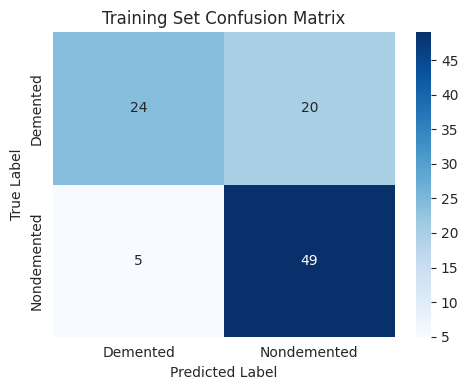

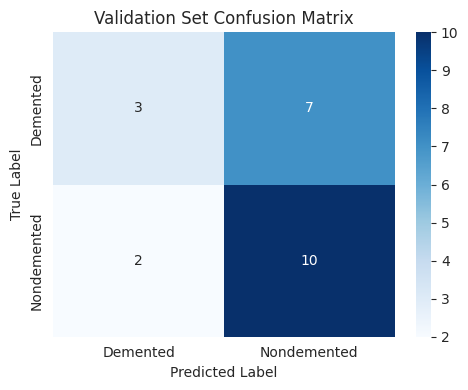

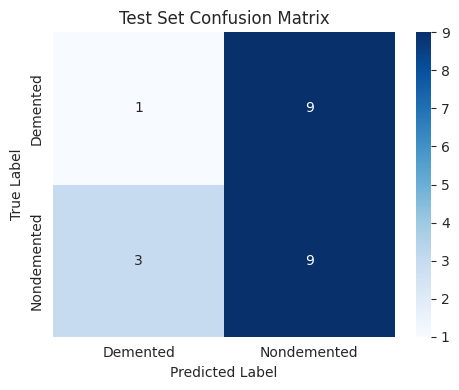

In [518]:
# Define SVM hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],  # try different kernels
    'gamma': ['scale', 'auto'],           # only used for 'rbf' and 'poly'
}

# Initialize and fit model with GridSearchCV
svm_model = SVC(random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_preprocessed, y_train_encoded)

# Best model
best_svm = grid_search.best_estimator_

# Predictions
y_pred_train = best_svm.predict(X_train_preprocessed)
y_pred_val = best_svm.predict(X_val_preprocessed)
y_pred_test = best_svm.predict(X_test_preprocessed)

# Accuracy scores
train_acc = accuracy_score(y_train_encoded, y_pred_train)
val_acc = accuracy_score(y_val_encoded, y_pred_val)
test_acc = accuracy_score(y_test_encoded, y_pred_test)

# Display accuracy
print("Best Parameters:", grid_search.best_params_)
print(f"\nTraining Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test_encoded, y_pred_test, target_names=le.classes_))

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot all confusion matrices
plot_conf_matrix(y_train_encoded, y_pred_train, "Training Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_val_encoded, y_pred_val, "Validation Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_test_encoded, y_pred_test, "Test Set Confusion Matrix", le.classes_)


Fairness Evaluation of SVM

In [519]:
# Get predictions from the best SVM model
y_pred_best = best_svm.predict(X_test_preprocessed)

# Reconstruct the 'M/F' sensitive attribute from original test data
X_test_with_gender = X_test.copy()
X_test_with_gender['M/F'] = X_test['M/F'].apply(lambda x: 1 if x == 'M' else 0)  # 1 = Male, 0 = Female

# Create BinaryLabelDataset for true labels
test_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([
        X_test_with_gender.reset_index(drop=True),
        pd.Series(y_test_encoded, name='label')
    ], axis=1),
    label_names=['label'],
    protected_attribute_names=['M/F']
)

# Create BinaryLabelDataset for predicted labels
pred_dataset = test_dataset.copy()
pred_dataset.labels = y_pred_best.reshape(-1, 1)

# Define privileged and unprivileged groups
privileged_groups = [{'M/F': 1}]      # Males
unprivileged_groups = [{'M/F': 0}]    # Females

# Compute fairness metrics
metric = ClassificationMetric(
    test_dataset, pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Extract fairness metrics
equal_opportunity_diff = metric.equal_opportunity_difference()
average_odds_diff = metric.average_odds_difference()
stat_parity_diff = metric.statistical_parity_difference()
disparate_impact = metric.disparate_impact()
theil_index = metric.theil_index()

# Print results
print("\n Fairness Metrics for SVM:")
print(f"EOD:     {equal_opportunity_diff:.4f}")
print(f"AOD:     {average_odds_diff:.4f}")
print(f"SPD:     {stat_parity_diff:.4f}")
print(f"DI       {disparate_impact:.4f}")
print(f"TI:      {theil_index:.4f}")



 Fairness Metrics for SVM:
EOD:     0.3750
AOD:     0.2875
SPD:     0.3077
DI       1.4444
TI:      0.2044


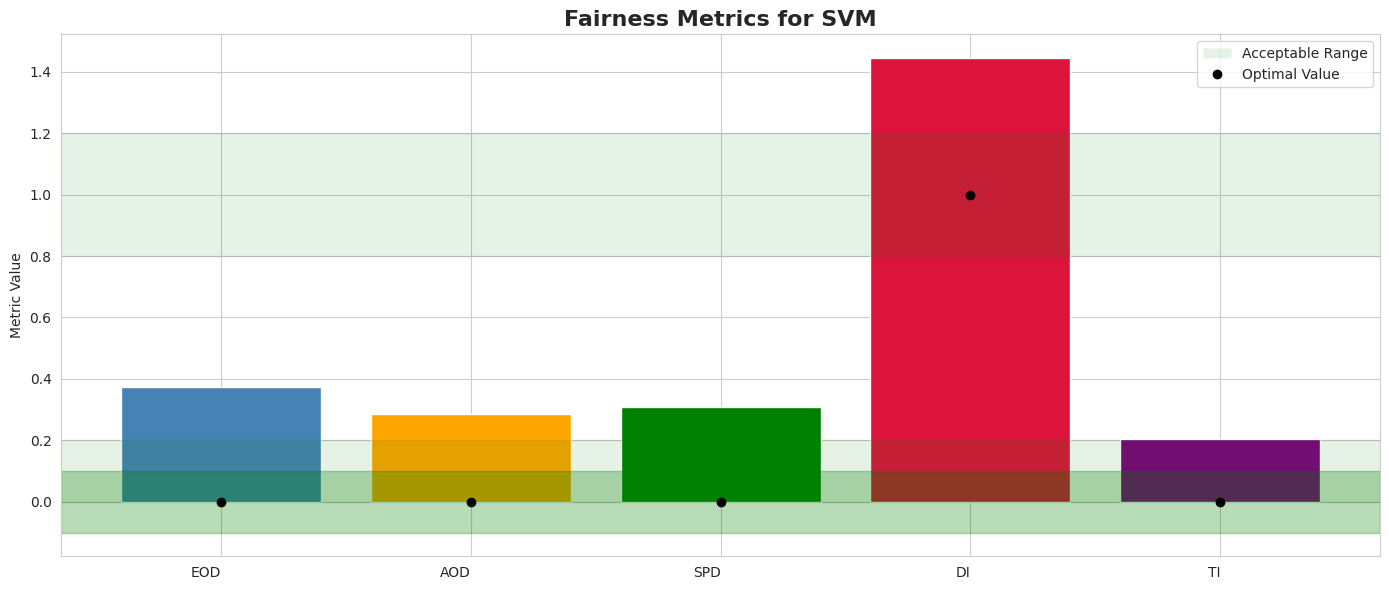

In [520]:
# Fairness metric values for SVM (replace these with your actual values)
metrics = {
    "EOD": equal_opportunity_diff,
    "AOD": average_odds_diff,
    "SPD": stat_parity_diff,
    "DI": disparate_impact,
    "TI": theil_index
}

# Optimal values for each metric (the ideal target)
optimal_values = [0, 0, 0, 1, 0]

# Acceptable range for each metric (used for green background bands)
acceptable_range = {
    "min": [-0.1, -0.1, -0.1, 0.8, 0],
    "max": [0.1, 0.1, 0.1, 1.2, 0.2]
}

# Plot setup
labels = list(metrics.keys())
values = list(metrics.values())
colors = ['steelblue', 'orange', 'green', 'crimson', 'purple']

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(labels, values, color=colors)

# Add acceptable range as shaded regions
for i, label in enumerate(labels):
    ax.axhspan(acceptable_range["min"][i], acceptable_range["max"][i],
               color='green', alpha=0.1)

# Add optimal value as black dot
for i, opt in enumerate(optimal_values):
    ax.plot(i, opt, marker='o', color='black', markersize=6, label='Optimal Value' if i == 0 else "")

# Styling
ax.set_title("Fairness Metrics for SVM", fontsize=16, fontweight='bold')
ax.set_ylabel("Metric Value")
plt.xticks(rotation=0, ha='right')

# Custom legend
legend_elements = [
    Patch(facecolor='green', alpha=0.1, label='Acceptable Range'),
    plt.Line2D([0], [0], marker='o', color='black', label='Optimal Value', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


SHAP Summary for Explainability of features on SVM

<ipython-input-522-3c9cb7182314>:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())


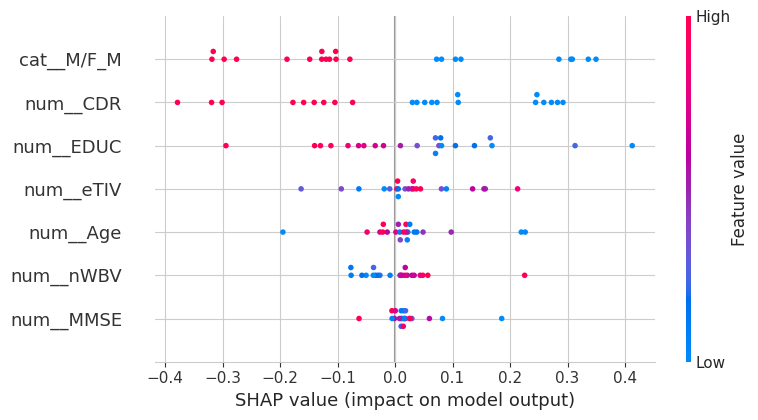

In [522]:
# Use a sample of the training set for SHAP explanation (to keep it fast & interpretable)
X_sample = X_train_preprocessed[:100]  # Adjust size if needed

# Create SHAP explainer for SVM (KernelExplainer is used for non-linear models like SVC)
explainer = shap.Explainer(best_svm.predict, X_sample, feature_names=preprocessor.get_feature_names_out())

# Compute SHAP values for the test set
shap_values = explainer(X_test_preprocessed)

# Summary plot: Shows global feature importance
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())


Random Forest

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}

Training Accuracy:   1.0000
Validation Accuracy: 0.5909
Test Accuracy:       0.5000

Test Set Classification Report:
              precision    recall  f1-score   support

    Demented       0.44      0.40      0.42        10
 Nondemented       0.54      0.58      0.56        12

    accuracy                           0.50        22
   macro avg       0.49      0.49      0.49        22
weighted avg       0.50      0.50      0.50        22



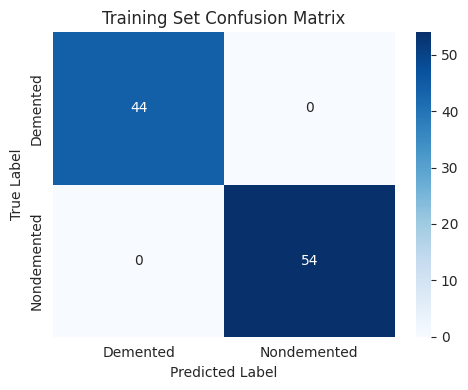

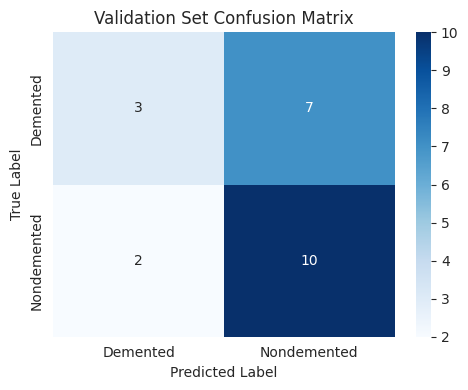

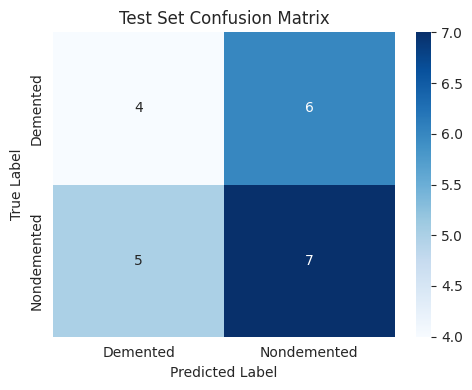

In [523]:
# Define Random Forest hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

# Initialize and fit Random Forest with GridSearchCV
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train_encoded)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred_train = best_rf.predict(X_train_preprocessed)
y_pred_val = best_rf.predict(X_val_preprocessed)
y_pred_test = best_rf.predict(X_test_preprocessed)

# Accuracy scores
train_acc = accuracy_score(y_train_encoded, y_pred_train)
val_acc = accuracy_score(y_val_encoded, y_pred_val)
test_acc = accuracy_score(y_test_encoded, y_pred_test)

# Display accuracy
print("Best Parameters:", grid_search.best_params_)
print(f"\nTraining Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test_encoded, y_pred_test, target_names=le.classes_))

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot all confusion matrices
plot_conf_matrix(y_train_encoded, y_pred_train, "Training Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_val_encoded, y_pred_val, "Validation Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_test_encoded, y_pred_test, "Test Set Confusion Matrix", le.classes_)


Fairness Evaluation of Random Forest

In [524]:
# Get predictions from the best Random Forest model
y_pred_best = best_rf.predict(X_test_preprocessed)

# Reconstruct the 'M/F' sensitive attribute from original test data
X_test_with_gender = X_test.copy()
X_test_with_gender['M/F'] = X_test['M/F'].apply(lambda x: 1 if x == 'M' else 0)  # 1 = Male, 0 = Female

# Create BinaryLabelDataset for true labels
test_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([
        X_test_with_gender.reset_index(drop=True),
        pd.Series(y_test_encoded, name='label')
    ], axis=1),
    label_names=['label'],
    protected_attribute_names=['M/F']
)

# Create BinaryLabelDataset for predicted labels
pred_dataset = test_dataset.copy()
pred_dataset.labels = y_pred_best.reshape(-1, 1)

# Define privileged and unprivileged groups
privileged_groups = [{'M/F': 1}]      # Males
unprivileged_groups = [{'M/F': 0}]    # Females

# Compute fairness metrics
metric = ClassificationMetric(
    test_dataset, pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Extract fairness metrics
equal_opportunity_diff = metric.equal_opportunity_difference()
average_odds_diff = metric.average_odds_difference()
stat_parity_diff = metric.statistical_parity_difference()
disparate_impact = metric.disparate_impact()
theil_index = metric.theil_index()

# Print results
print("\n Fairness Metrics for Random Forest:")
print(f"EOD:     {equal_opportunity_diff:.4f}")
print(f"AOD:     {average_odds_diff:.4f}")
print(f"SPD:     {stat_parity_diff:.4f}")
print(f"DI:      {disparate_impact:.4f}")
print(f"TI:      {theil_index:.4f}")



 Fairness Metrics for Random Forest:
EOD:     0.2500
AOD:     0.1250
SPD:     0.1282
DI:      1.2381
TI:      0.3172


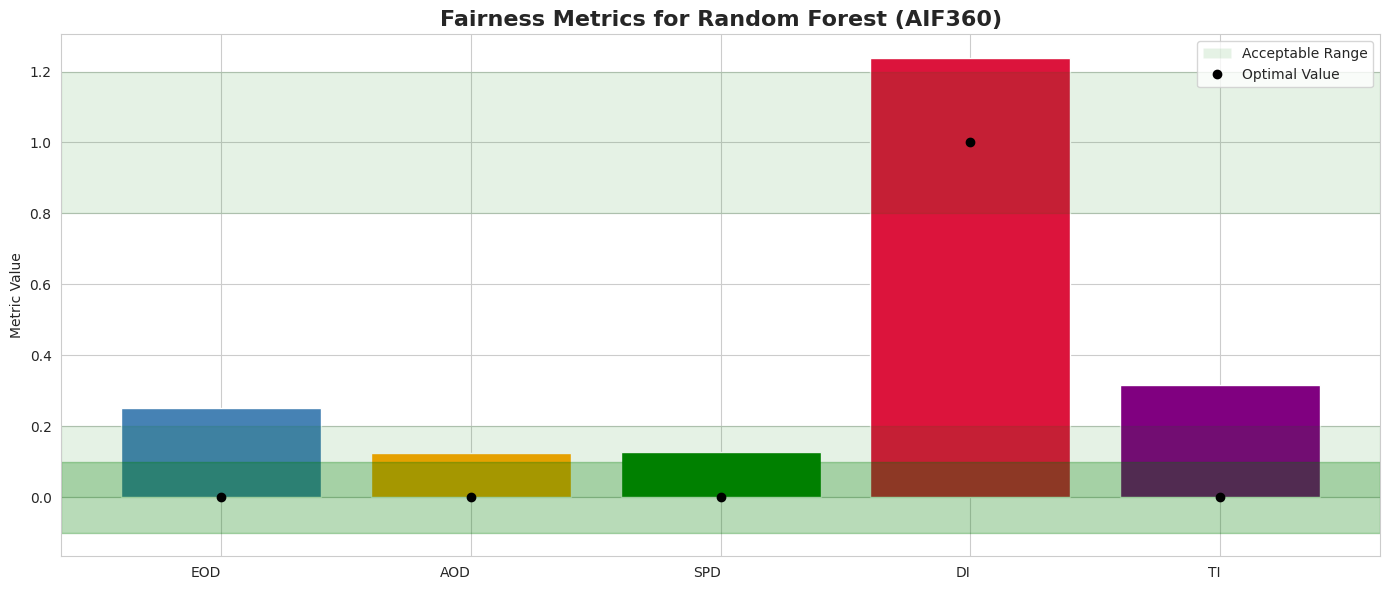

In [525]:
# Use the actual fairness metric values from your output
metrics = {
    "EOD": equal_opportunity_diff,
    "AOD": average_odds_diff,
    "SPD": stat_parity_diff,
    "DI": disparate_impact,
    "TI": theil_index
}

# Ideal values for each fairness metric
optimal_values = [0, 0, 0, 1, 0]  # Perfect fairness targets

# Define acceptable fairness bounds for visual reference
acceptable_range = {
    "min": [-0.1, -0.1, -0.1, 0.8, 0],
    "max": [0.1, 0.1, 0.1, 1.2, 0.2]
}

# Prepare data for plotting
labels = list(metrics.keys())
values = list(metrics.values())
colors = ['steelblue', 'orange', 'green', 'crimson', 'purple']

# Create plot
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(labels, values, color=colors)

# Shade acceptable range
for i in range(len(labels)):
    ax.axhspan(acceptable_range["min"][i], acceptable_range["max"][i], color='green', alpha=0.1)

# Mark optimal value with black dots
for i, opt in enumerate(optimal_values):
    ax.plot(i, opt, marker='o', color='black', markersize=6, label='Optimal Value' if i == 0 else "")

# Title and axis labels
ax.set_title("Fairness Metrics for Random Forest (AIF360)", fontsize=16, fontweight='bold')
ax.set_ylabel("Metric Value")
plt.xticks(rotation=0, ha='right')

# Add custom legend
legend_elements = [
    Patch(facecolor='green', alpha=0.1, label='Acceptable Range'),
    plt.Line2D([0], [0], marker='o', color='black', label='Optimal Value', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


SHAP Summary for Explainability of features on Random Forest

<ipython-input-526-3774798a4e6b>:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

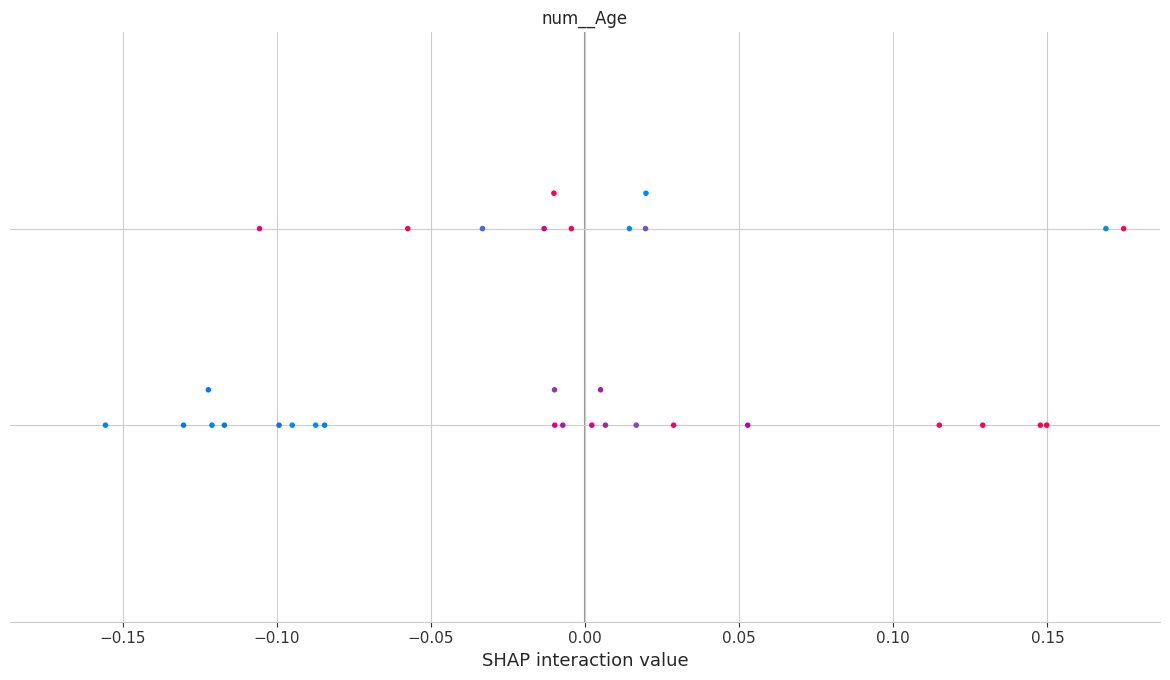

In [526]:
# Use a sample of the training set for SHAP explanation (to keep it fast & interpretable)
X_sample = X_train_preprocessed[:100]  # Adjust size if needed

# Create SHAP explainer for XGBoost using TreeExplainer
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_preprocessed)

# Summary plot: Shows global feature importance
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())


AdaBoost

Best Parameters: {'learning_rate': 1.0, 'n_estimators': 50}

Training Accuracy:   0.8061
Validation Accuracy: 0.4545
Test Accuracy:       0.5455

Test Set Classification Report:
              precision    recall  f1-score   support

    Demented       0.50      0.40      0.44        10
 Nondemented       0.57      0.67      0.62        12

    accuracy                           0.55        22
   macro avg       0.54      0.53      0.53        22
weighted avg       0.54      0.55      0.54        22



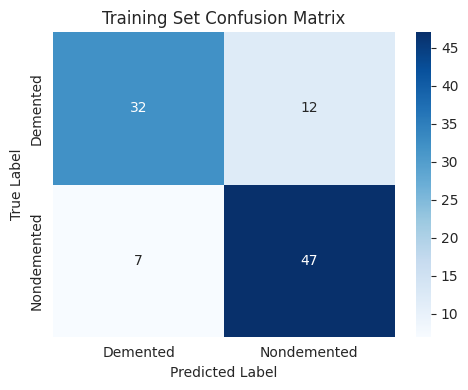

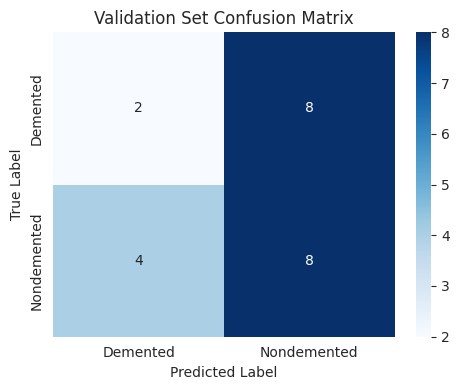

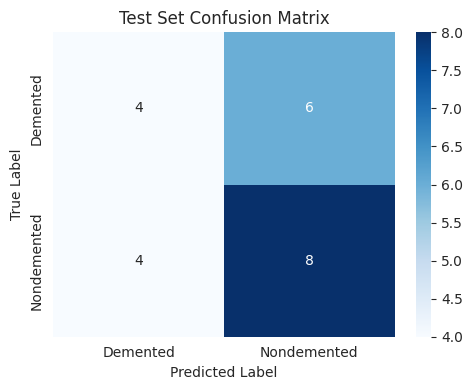

In [527]:
# Define AdaBoost hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Initialize and fit model with GridSearchCV
adaboost_model = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_preprocessed, y_train_encoded)

# Best model
best_adaboost = grid_search.best_estimator_

# Predictions
y_pred_train = best_adaboost.predict(X_train_preprocessed)
y_pred_val = best_adaboost.predict(X_val_preprocessed)
y_pred_test = best_adaboost.predict(X_test_preprocessed)

# Accuracy scores
train_acc = accuracy_score(y_train_encoded, y_pred_train)
val_acc = accuracy_score(y_val_encoded, y_pred_val)
test_acc = accuracy_score(y_test_encoded, y_pred_test)

# Display accuracy
print("Best Parameters:", grid_search.best_params_)
print(f"\nTraining Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test_encoded, y_pred_test, target_names=le.classes_))

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot all confusion matrices
plot_conf_matrix(y_train_encoded, y_pred_train, "Training Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_val_encoded, y_pred_val, "Validation Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_test_encoded, y_pred_test, "Test Set Confusion Matrix", le.classes_)


Fairness Evaluation of AdaBoost

In [528]:
# Get predictions from the best AdaBoost model
y_pred_best = best_adaboost.predict(X_test_preprocessed)

# Reconstruct the 'M/F' sensitive attribute from original test data
X_test_with_gender = X_test.copy()
X_test_with_gender['M/F'] = X_test['M/F'].apply(lambda x: 1 if x == 'M' else 0)  # 1 = Male, 0 = Female

# Create BinaryLabelDataset for true labels
test_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([
        X_test_with_gender.reset_index(drop=True),
        pd.Series(y_test_encoded, name='label')
    ], axis=1),
    label_names=['label'],
    protected_attribute_names=['M/F']
)

# Create BinaryLabelDataset for predicted labels
pred_dataset = test_dataset.copy()
pred_dataset.labels = y_pred_best.reshape(-1, 1)

# Define privileged and unprivileged groups
privileged_groups = [{'M/F': 1}]      # Males
unprivileged_groups = [{'M/F': 0}]    # Females

# Compute fairness metrics
metric = ClassificationMetric(
    test_dataset, pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Extract fairness metrics
equal_opportunity_diff = metric.equal_opportunity_difference()
average_odds_diff = metric.average_odds_difference()
stat_parity_diff = metric.statistical_parity_difference()
disparate_impact = metric.disparate_impact()
theil_index = metric.theil_index()

# Print results
print("\nFairness Metrics for AdaBoost Classifier:")
print(f"EOD:     {equal_opportunity_diff:.4f}")
print(f"AOD:     {average_odds_diff:.4f}")
print(f"SPD:     {stat_parity_diff:.4f}")
print(f"DI:      {disparate_impact:.4f}")
print(f"TI:      {theil_index:.4f}")



Fairness Metrics for AdaBoost Classifier:
EOD:     0.1250
AOD:     0.0625
SPD:     0.0513
DI:      1.0833
TI:      0.2596


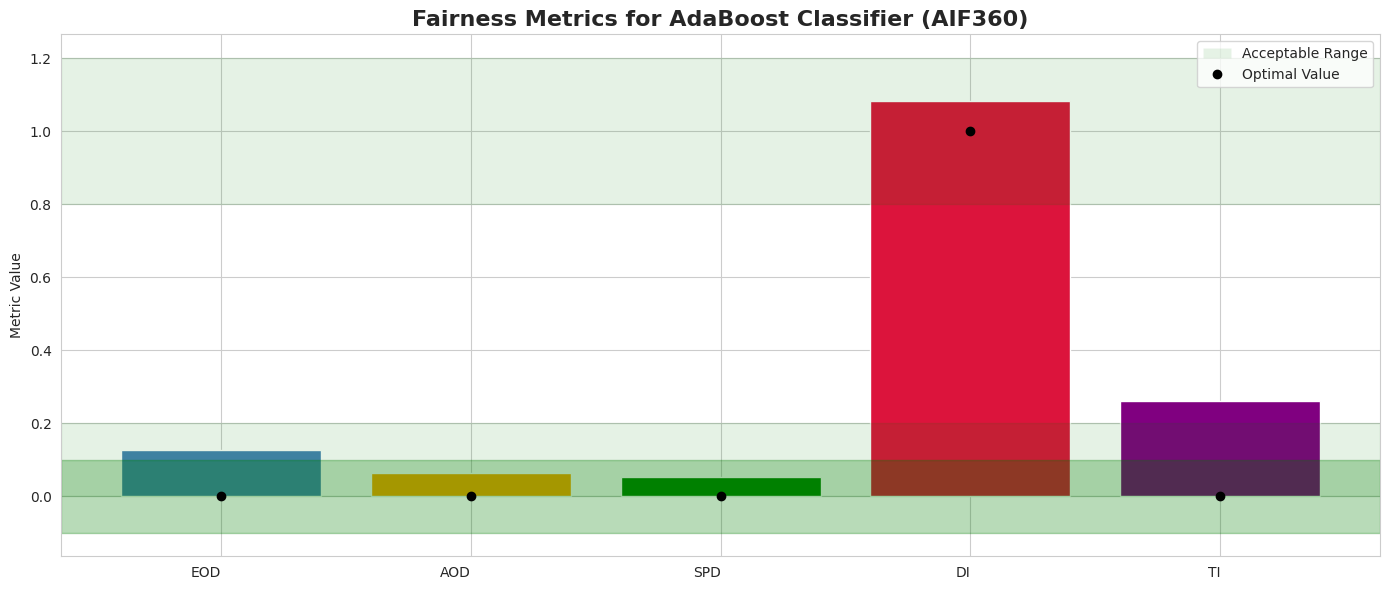

In [529]:
# Updated fairness metrics for AdaBoost
metrics = {
    "EOD": equal_opportunity_diff,
    "AOD": average_odds_diff,
    "SPD": stat_parity_diff,
    "DI": disparate_impact,
    "TI": theil_index
}

# Ideal values for each fairness metric
optimal_values = [0, 0, 0, 1, 0]  # Ideal: no bias

# Acceptable bounds (±0.1 for EOD, AOD, SPD; 0.8–1.2 for DI; <0.2 for TI)
acceptable_range = {
    "min": [-0.1, -0.1, -0.1, 0.8, 0],
    "max": [0.1, 0.1, 0.1, 1.2, 0.2]
}

# Plotting setup
labels = list(metrics.keys())
values = list(metrics.values())
colors = ['steelblue', 'orange', 'green', 'crimson', 'purple']

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(labels, values, color=colors)

# Highlight acceptable ranges
for i in range(len(labels)):
    ax.axhspan(acceptable_range["min"][i], acceptable_range["max"][i], color='green', alpha=0.1)

# Mark optimal values
for i, opt in enumerate(optimal_values):
    ax.plot(i, opt, marker='o', color='black', markersize=6, label='Optimal Value' if i == 0 else "")

# Labeling
ax.set_title("Fairness Metrics for AdaBoost Classifier (AIF360)", fontsize=16, fontweight='bold')
ax.set_ylabel("Metric Value")
plt.xticks(rotation=0, ha='right')

# Custom legend
legend_elements = [
    Patch(facecolor='green', alpha=0.1, label='Acceptable Range'),
    plt.Line2D([0], [0], marker='o', color='black', label='Optimal Value', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


SHAP Summary for Explainability of features on AdaBoost

  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-530-a9460a05a75e>:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())


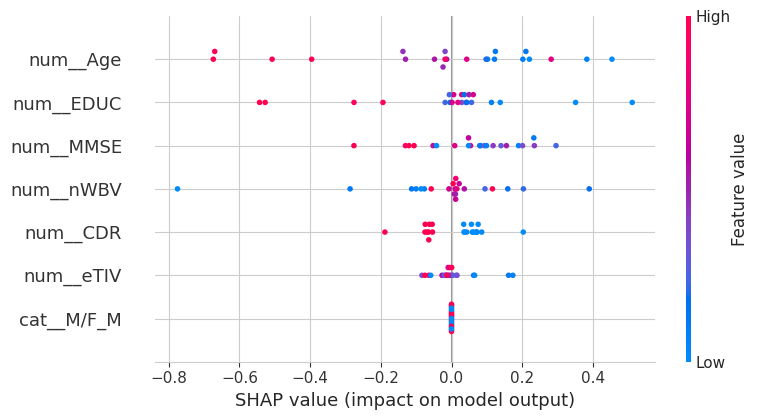

In [530]:
# Use a sample of the training set for SHAP explanation (to keep it fast & interpretable)
X_sample = X_train_preprocessed[:100]  # Optional: reduce for speed

# Use KernelExplainer for AdaBoostClassifier, as TreeExplainer doesn't support it directly.
explainer = shap.KernelExplainer(best_adaboost.predict, X_sample, feature_names=preprocessor.get_feature_names_out())

# Compute SHAP values on test set
shap_values = explainer.shap_values(X_test_preprocessed)

# Plot summary
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Training Accuracy:   0.8980
Validation Accuracy: 0.6364
Test Accuracy:       0.6364

Test Set Classification Report:
              precision    recall  f1-score   support

    Demented       1.00      0.20      0.33        10
 Nondemented       0.60      1.00      0.75        12

    accuracy                           0.64        22
   macro avg       0.80      0.60      0.54        22
weighted avg       0.78      0.64      0.56        22



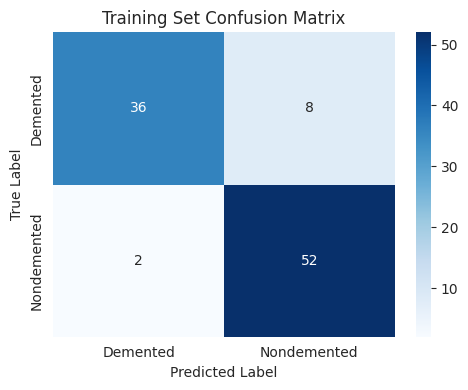

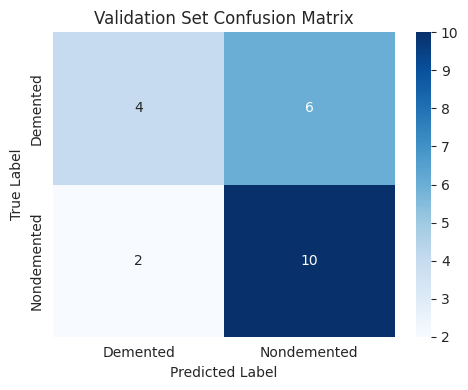

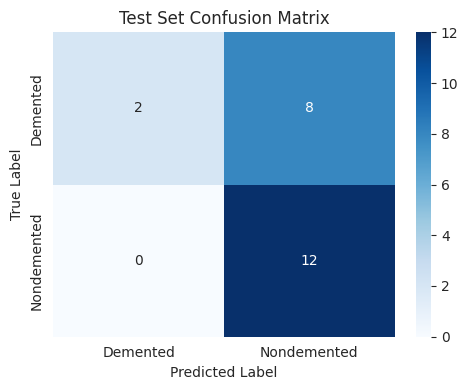

In [531]:
# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize and fit model with GridSearchCV
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train_encoded)

# Best model
best_xgb = grid_search.best_estimator_

# Predictions
y_pred_train = best_xgb.predict(X_train_preprocessed)
y_pred_val = best_xgb.predict(X_val_preprocessed)
y_pred_test = best_xgb.predict(X_test_preprocessed)

# Accuracy scores
train_acc = accuracy_score(y_train_encoded, y_pred_train)
val_acc = accuracy_score(y_val_encoded, y_pred_val)
test_acc = accuracy_score(y_test_encoded, y_pred_test)

# Display accuracy
print("Best Parameters:", grid_search.best_params_)
print(f"\nTraining Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test_encoded, y_pred_test, target_names=le.classes_))

# Confusion matrix plot function
def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot all confusion matrices
plot_conf_matrix(y_train_encoded, y_pred_train, "Training Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_val_encoded, y_pred_val, "Validation Set Confusion Matrix", le.classes_)
plot_conf_matrix(y_test_encoded, y_pred_test, "Test Set Confusion Matrix", le.classes_)


Fairness Evaluation of XGBoost

In [532]:
# Get predictions from the best XGBoost model
y_pred_best = best_xgb.predict(X_test_preprocessed)

# Reconstruct the 'M/F' sensitive attribute from original test data
X_test_with_gender = X_test.copy()
X_test_with_gender['M/F'] = X_test['M/F'].apply(lambda x: 1 if x == 'M' else 0)  # 1 = Male, 0 = Female

# Create BinaryLabelDataset for true labels
test_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([
        X_test_with_gender.reset_index(drop=True),
        pd.Series(y_test_encoded, name='label')
    ], axis=1),
    label_names=['label'],
    protected_attribute_names=['M/F']
)

# Create BinaryLabelDataset for predicted labels
pred_dataset = test_dataset.copy()
pred_dataset.labels = y_pred_best.reshape(-1, 1)

# Define privileged and unprivileged groups
privileged_groups = [{'M/F': 1}]      # Males
unprivileged_groups = [{'M/F': 0}]    # Females

# Compute fairness metrics
metric = ClassificationMetric(
    test_dataset, pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Extract fairness metrics
equal_opportunity_diff = metric.equal_opportunity_difference()
average_odds_diff = metric.average_odds_difference()
stat_parity_diff = metric.statistical_parity_difference()
disparate_impact = metric.disparate_impact()
theil_index = metric.theil_index()

# Print results
print("\nFairness Metrics for XGBoost:")
print(f"EOD:     {equal_opportunity_diff:.4f}")
print(f"AOD:     {average_odds_diff:.4f}")
print(f"SPD:     {stat_parity_diff:.4f}")
print(f"DI:      {disparate_impact:.4f}")
print(f"TI:      {theil_index:.4f}")



Fairness Metrics for XGBoost:
EOD:     0.0000
AOD:     0.0000
SPD:     -0.0342
DI:      0.9630
TI:      0.0595


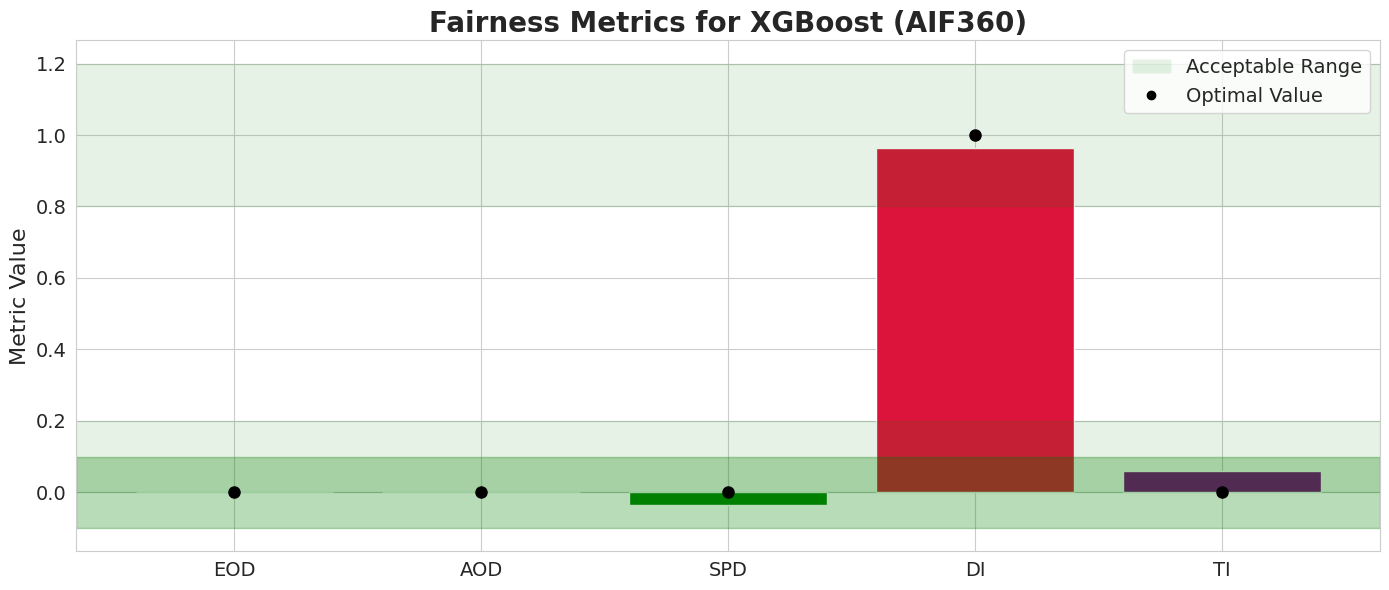

In [533]:
# Use the actual fairness metric values from your output
metrics = {
    "EOD": equal_opportunity_diff,
    "AOD": average_odds_diff,
    "SPD": stat_parity_diff,
    "DI": disparate_impact,
    "TI": theil_index
}

# Ideal values for each fairness metric
optimal_values = [0, 0, 0, 1, 0]  # Perfect fairness targets

# Define acceptable fairness bounds for visual reference
acceptable_range = {
    "min": [-0.1, -0.1, -0.1, 0.8, 0],
    "max": [0.1, 0.1, 0.1, 1.2, 0.2]
}

# Prepare data for plotting
labels = list(metrics.keys())
values = list(metrics.values())
colors = ['steelblue', 'orange', 'green', 'crimson', 'purple']

# Create plot
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(labels, values, color=colors)

# Shade acceptable range
for i in range(len(labels)):
    ax.axhspan(acceptable_range["min"][i], acceptable_range["max"][i], color='green', alpha=0.1)

# Mark optimal value with black dots
for i, opt in enumerate(optimal_values):
    ax.plot(i, opt, marker='o', color='black', markersize=8, label='Optimal Value' if i == 0 else "")

# Title and axis labels with larger fonts
ax.set_title("Fairness Metrics for XGBoost (AIF360)", fontsize=20, fontweight='bold')
ax.set_ylabel("Metric Value", fontsize=16)
ax.set_xlabel("")  # Optional, if you want to label the x-axis
ax.tick_params(axis='both', labelsize=14)  # Increase tick label font size

# Add custom legend with larger font
legend_elements = [
    Patch(facecolor='green', alpha=0.1, label='Acceptable Range'),
    plt.Line2D([0], [0], marker='o', color='black', label='Optimal Value', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()


SHAP Summary for Explainability of features on XGBoost

<ipython-input-534-a158cf6af4dc>:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())


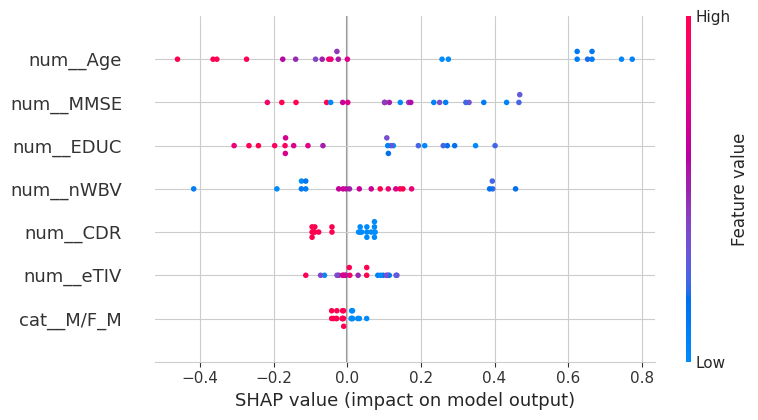

In [534]:
# Use a sample of the training set for SHAP explanation (to keep it fast & interpretable)
X_sample = X_train_preprocessed[:100]  # Adjust size if needed

# Create SHAP explainer for XGBoost using TreeExplainer
explainer = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_preprocessed)

# Summary plot: Shows global feature importance
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())


Comparative Fairness Evaluation of Machine Learning Models Using AIF360 Metrics

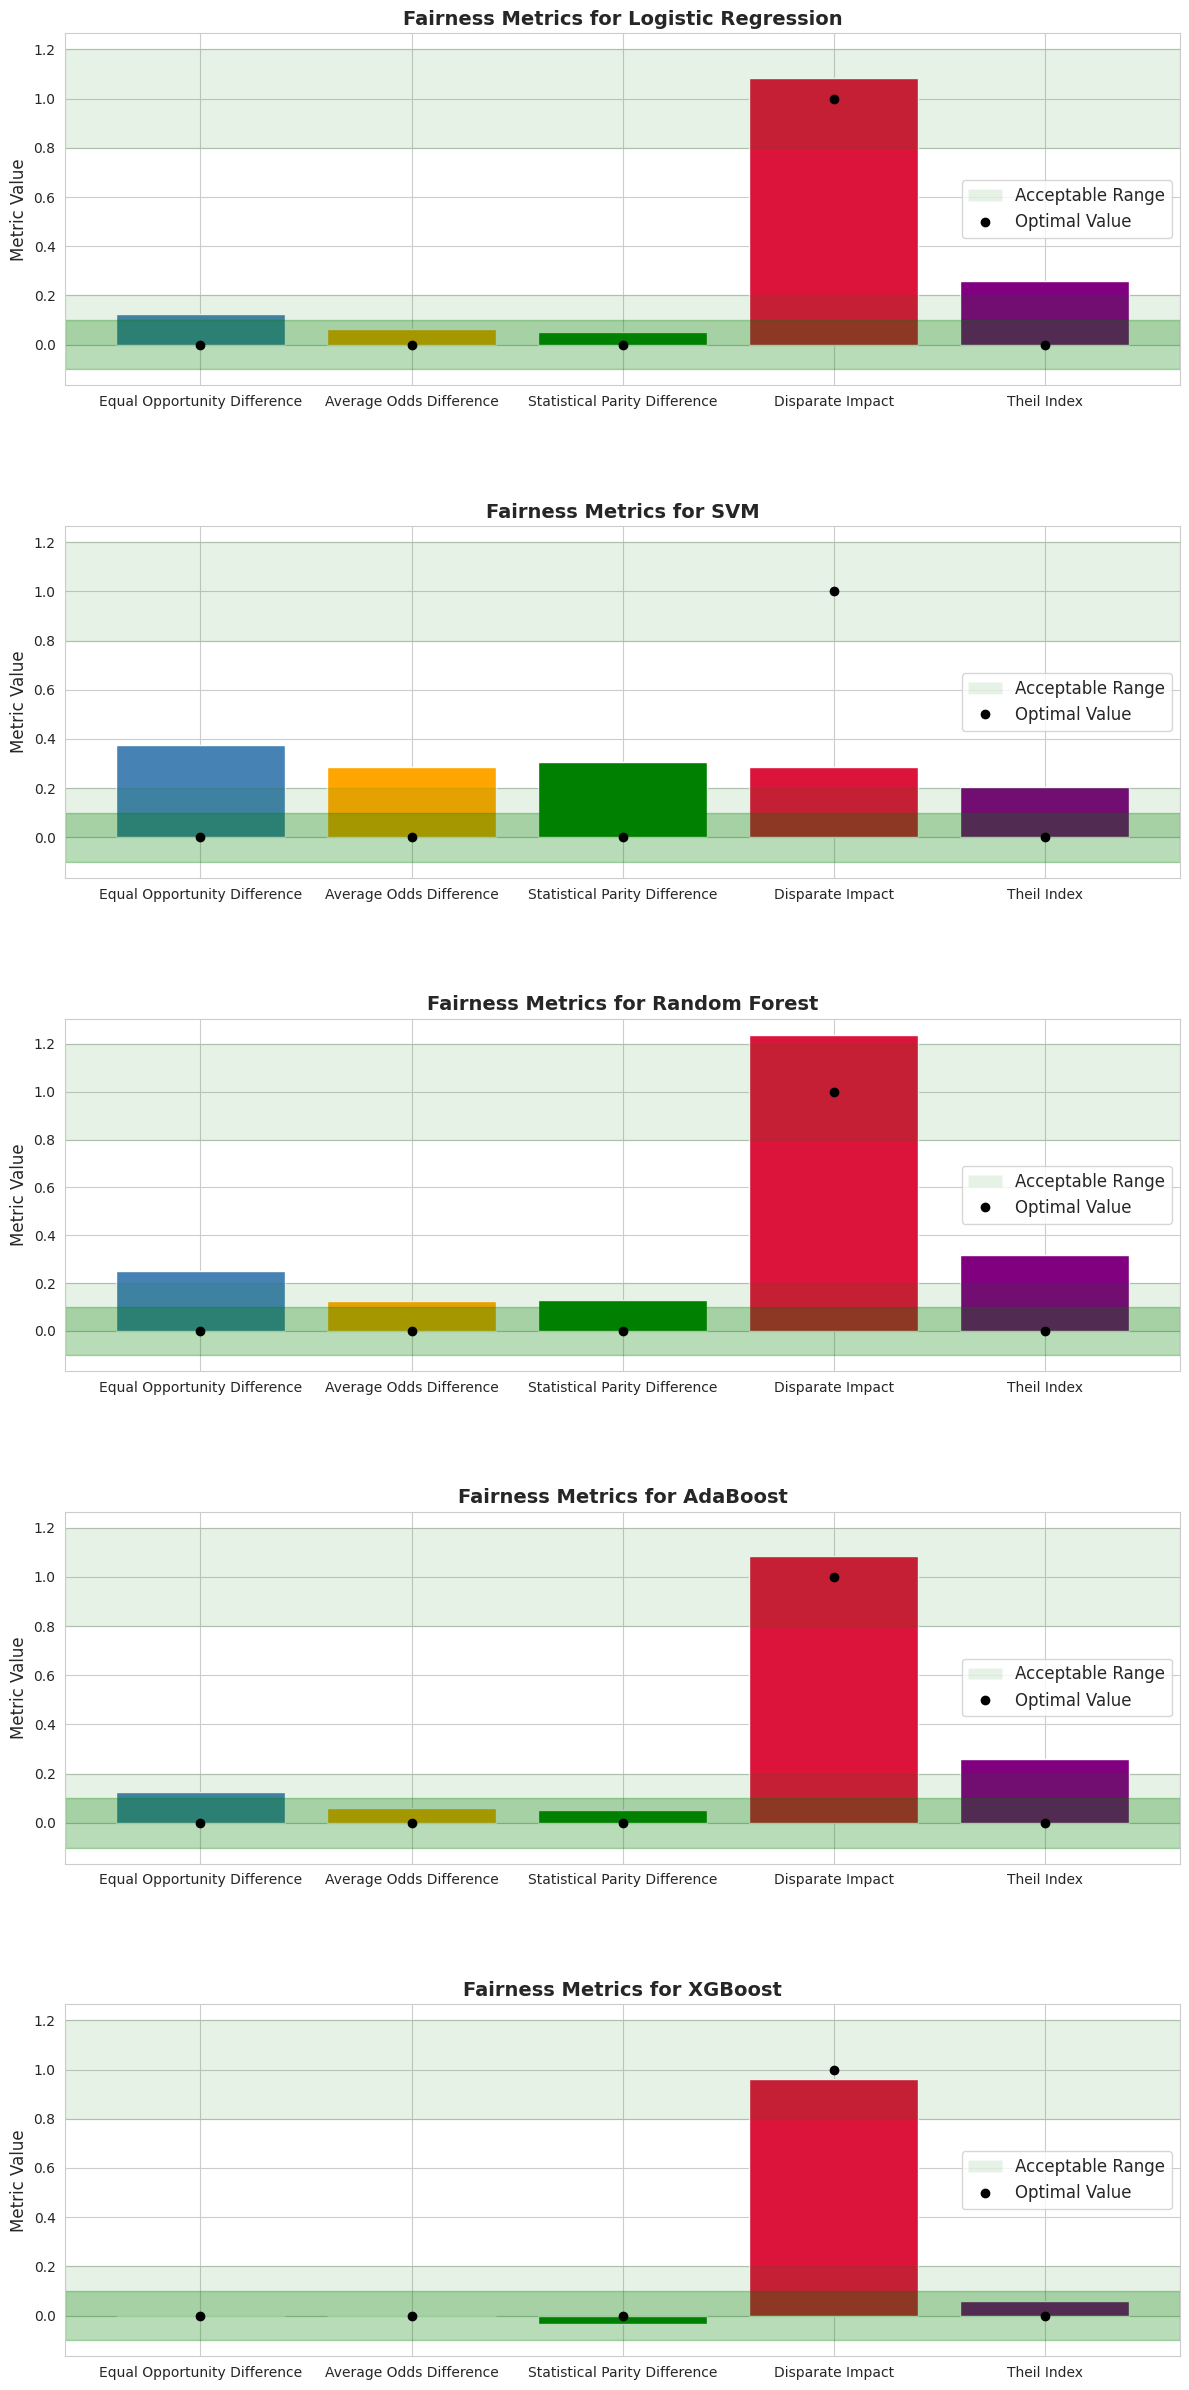

In [535]:
# Define a function to create a fairness bar chart for a given model
def plot_fairness(ax, metrics, title):
    labels = list(metrics.keys())
    values = list(metrics.values())
    colors = ['steelblue', 'orange', 'green', 'crimson', 'purple']
    optimal_values = [0, 0, 0, 1, 0]
    acceptable_range = {
        "min": [-0.1, -0.1, -0.1, 0.8, 0],
        "max": [0.1, 0.1, 0.1, 1.2, 0.2]
    }

    ax.bar(labels, values, color=colors)

    for i in range(len(labels)):
        ax.axhspan(acceptable_range["min"][i], acceptable_range["max"][i], color='green', alpha=0.1)
        ax.plot(i, optimal_values[i], marker='o', color='black', markersize=6)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("Metric Value", fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

# Fairness metrics for each model
models = {
    "Logistic Regression": {
        "Equal Opportunity Difference": 0.1250, "Average Odds Difference": 0.0625, "Statistical Parity Difference": 0.0513, "Disparate Impact": 1.0833, "Theil Index": 0.2593
    },
    "SVM": {
        "Equal Opportunity Difference": 0.3750, "Average Odds Difference": 0.2875, "Statistical Parity Difference": 0.3077, "Disparate Impact": 0.2875, "Theil Index": 0.2044
    },
    "Random Forest": {
        "Equal Opportunity Difference": 0.2500, "Average Odds Difference": 0.1250, "Statistical Parity Difference": 0.1282, "Disparate Impact": 1.2381, "Theil Index": 0.3172
    },
    "AdaBoost": {
        "Equal Opportunity Difference": 0.1250, "Average Odds Difference": 0.0625, "Statistical Parity Difference": 0.0513, "Disparate Impact": 1.0833, "Theil Index": 0.2596
    },
    "XGBoost": {
        "Equal Opportunity Difference": 0.0000, "Average Odds Difference": 0.0000, "Statistical Parity Difference": -0.0342, "Disparate Impact": 0.9630, "Theil Index": 0.0595
    }
}

# Create a 5-row single-column subplot layout
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 24))

# Plot each model
for i, (model_name, metric_values) in enumerate(models.items()):
    plot_fairness(axes[i], metric_values, f"Fairness Metrics for {model_name}")

# Add a common legend to the last plot
legend_elements = [
    Patch(facecolor='green', alpha=0.1, label='Acceptable Range'),
    plt.Line2D([0], [0], marker='o', color='black', label='Optimal Value', linestyle='None')
]
axes[-5].legend(handles=legend_elements, loc='right', fontsize=12)
axes[-4].legend(handles=legend_elements, loc='right', fontsize=12)
axes[-3].legend(handles=legend_elements, loc='right', fontsize=12)
axes[-2].legend(handles=legend_elements, loc='right', fontsize=12)
axes[-1].legend(handles=legend_elements, loc='right', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()
